In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers
from keras import Model
from keras import Input
from keras.utils import plot_model
from keras.layers import concatenate

import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load
from keras.models import load_model
import seaborn as sb
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

# comment the below line if you not using jupyter notebook
%matplotlib inline

In [2]:
print("Started reading the data for training...")
df_ = pd.read_csv('train.csv')
df = df_.copy()
# df_training = df.iloc[:,:].copy()
print("Finished reading the data")

Started reading the data for training...
Finished reading the data


In [3]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['color_type'])
df['color_type'] = le.transform(df['color_type'])

In [5]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc_y1 = OneHotEncoder(handle_unknown='ignore')
enc_y1.fit(df[['breed_category']])
y1 = enc_y1.transform(df[['breed_category']]).toarray()
enc_y2 = OneHotEncoder(handle_unknown='ignore')
enc_y2.fit(df[['pet_category']])
y2 = enc_y2.transform(df[['pet_category']]).toarray()

In [7]:
df[['condition']] = df[['condition']].fillna(3.0)

In [8]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3.0,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [9]:
x = df[['condition', 'color_type', 'length(m)', 'height(cm)', 'X1', 'X2']].values

In [10]:
def scaleData(x, y):
    sc_x = StandardScaler()
    sc_y = StandardScaler()

    sc_x.fit(x)
    sc_y.fit(y)
    
    return sc_x, sc_y

In [11]:
sc_x, sc_y = scaleData(x,y1)

In [12]:
x_scaled = sc_x.transform(x)

In [13]:
x_train = x_scaled[:,:]
y_train1 = y1[:,:]
y_train2 = y2[:,:]
x_val = x_scaled[15000:,:]
y_val1 = y1[15000:,:]
y_val2 = y2[15000:,:]

In [47]:
base = load_model('model_cond-4-64-split_2.h5')

In [48]:
Kreg = regularizers.l2(1e-4)

inp = Input(shape = (x_train.shape[1],), name = 'x')
layer1 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 1), kernel_regularizer = Kreg)(inp)

layer2 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 2), kernel_regularizer = Kreg)(layer1)

layer3 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 3), kernel_regularizer = Kreg)(layer2)

y1 = Dense(3, activation = 'softmax', name = 'y1',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg)(layer3)

y2 = Dense(4, activation = 'softmax', name = 'y2',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg)(layer3)

model = Model(
    inputs=inp,
    outputs=[y1, y2]
)

model.load_weights('model_cond-4-64-split_2.h5')

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           448         x[0][0]                          
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           4160        dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           4160        dense_4[0][0]                    
____________________________________________________________________________________________

In [110]:
adam = Adam(learning_rate = 0.000003)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('model_cond-4-64-split_3.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(
    x = {'x':x_train},
    y = {'y1':y_train1, 'y2':y_train2},
    epochs=10000, batch_size=32,
    validation_data = ({'x':x_val},
                       {'y1':y_val1, 'y2':y_val2}),
    verbose = 1, callbacks = callbacks)

Epoch 1/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1423 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8744
Epoch 00001: loss improved from inf to 0.48466, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4847 - y1_loss: 0.1422 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8745 - val_loss: 0.5244 - val_y1_loss: 0.1528 - val_y2_loss: 0.3265 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8641
Epoch 2/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1418 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8753
Epoch 00002: loss improved from 0.48466 to 0.48463, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 

Epoch 16/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4847 - y1_loss: 0.1423 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8747
Epoch 00016: loss did not improve from 0.48462
589/589 [==============================] - 1s 3ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8747 - val_loss: 0.5244 - val_y1_loss: 0.1528 - val_y2_loss: 0.3264 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8646
Epoch 17/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1416 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754
Epoch 00017: loss improved from 0.48462 to 0.48459, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8751 -

Epoch 31/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1419 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754
Epoch 00031: loss did not improve from 0.48457
589/589 [==============================] - 1s 2ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5243 - val_y1_loss: 0.1528 - val_y2_loss: 0.3264 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8641
Epoch 32/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4839 - y1_loss: 0.1422 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8753
Epoch 00032: loss did not improve from 0.48457
589/589 [==============================] - 1s 2ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5243 - val_y1_loss: 0.1528 - val_y2

Epoch 46/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1419 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8752
Epoch 00046: loss did not improve from 0.48455
589/589 [==============================] - 1s 2ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5243 - val_y1_loss: 0.1528 - val_y2_loss: 0.3263 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8636
Epoch 47/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1419 - y2_loss: 0.2974 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8749
Epoch 00047: loss improved from 0.48455 to 0.48455, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8751 -

Epoch 61/10000
589/589 [==============================] - ETA: 0s - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754
Epoch 00061: loss did not improve from 0.48452
589/589 [==============================] - 1s 2ms/step - loss: 0.4846 - y1_loss: 0.1422 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5242 - val_y1_loss: 0.1527 - val_y2_loss: 0.3263 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8644
Epoch 62/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4844 - y1_loss: 0.1412 - y2_loss: 0.2980 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8737
Epoch 00062: loss did not improve from 0.48452
589/589 [==============================] - 1s 2ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8747 - val_loss: 0.5242 - val_y1_loss: 0.1528 - val_y2

Epoch 76/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4848 - y1_loss: 0.1420 - y2_loss: 0.2976 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8747
Epoch 00076: loss did not improve from 0.48450
589/589 [==============================] - 2s 3ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5241 - val_y1_loss: 0.1527 - val_y2_loss: 0.3262 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8638
Epoch 77/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4833 - y1_loss: 0.1416 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8756
Epoch 00077: loss did not improve from 0.48450
589/589 [==============================] - 1s 2ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5241 - val_y1_loss: 0.1527 - val_y2

Epoch 91/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1417 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8746- ETA: 2s - loss: 0.4942 - y1_loss: 0.1431 - y2_loss: 0.3059 - y1_categorical_accuracy: 0.9176
Epoch 00091: loss did not improve from 0.48447
589/589 [==============================] - 3s 6ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5241 - val_y1_loss: 0.1527 - val_y2_loss: 0.3262 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8638
Epoch 92/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4849 - y1_loss: 0.1426 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8749
Epoch 00092: loss did not improve from 0.48447
589/589 [==============================] - 2s 3ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accura

Epoch 106/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1417 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8753
Epoch 00106: loss did not improve from 0.48445
589/589 [==============================] - 1s 2ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5240 - val_y1_loss: 0.1527 - val_y2_loss: 0.3261 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8638
Epoch 107/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1416 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8745
Epoch 00107: loss did not improve from 0.48445
589/589 [==============================] - 1s 2ms/step - loss: 0.4845 - y1_loss: 0.1422 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8747 - val_loss: 0.5240 - val_y1_loss: 0.1527 - val_

Epoch 121/10000
589/589 [==============================] - ETA: 0s - loss: 0.4844 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8749
Epoch 00121: loss did not improve from 0.48441
589/589 [==============================] - 1s 2ms/step - loss: 0.4844 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8749 - val_loss: 0.5240 - val_y1_loss: 0.1527 - val_y2_loss: 0.3260 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8644
Epoch 122/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1419 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8750
Epoch 00122: loss did not improve from 0.48441
589/589 [==============================] - 1s 2ms/step - loss: 0.4844 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5240 - val_y1_loss: 0.1527 - val_

Epoch 136/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4857 - y1_loss: 0.1427 - y2_loss: 0.2977 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8741
Epoch 00136: loss did not improve from 0.48438
589/589 [==============================] - 1s 2ms/step - loss: 0.4844 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8748 - val_loss: 0.5239 - val_y1_loss: 0.1527 - val_y2_loss: 0.3260 - val_y1_categorical_accuracy: 0.9087 - val_y2_categorical_accuracy: 0.8646
Epoch 137/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1412 - y2_loss: 0.2977 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8743
Epoch 00137: loss did not improve from 0.48438
589/589 [==============================] - 2s 3ms/step - loss: 0.4844 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5239 - val_y1_loss: 0.1527 - val_

Epoch 151/10000
589/589 [==============================] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8749
Epoch 00151: loss improved from 0.48436 to 0.48435, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8749 - val_loss: 0.5238 - val_y1_loss: 0.1527 - val_y2_loss: 0.3260 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8641
Epoch 152/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1428 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9166 - y2_categorical_accuracy: 0.8763
Epoch 00152: loss did not improve from 0.48435
589/589 [==============================] - 1s 2ms/step - loss: 0.4844 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8752

Epoch 166/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4855 - y1_loss: 0.1428 - y2_loss: 0.2975 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8746
Epoch 00166: loss improved from 0.48434 to 0.48433, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5238 - val_y1_loss: 0.1527 - val_y2_loss: 0.3259 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8652
Epoch 167/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4848 - y1_loss: 0.1428 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9170 - y2_categorical_accuracy: 0.8745
Epoch 00167: loss did not improve from 0.48433
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8747

Epoch 181/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4857 - y1_loss: 0.1427 - y2_loss: 0.2978 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8752
Epoch 00181: loss did not improve from 0.48428
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5237 - val_y1_loss: 0.1527 - val_y2_loss: 0.3258 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8638
Epoch 182/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4847 - y1_loss: 0.1418 - y2_loss: 0.2976 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8748
Epoch 00182: loss did not improve from 0.48428
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5237 - val_y1_loss: 0.1527 - val_

Epoch 196/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4839 - y1_loss: 0.1418 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8752
Epoch 00196: loss did not improve from 0.48428
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8749 - val_loss: 0.5237 - val_y1_loss: 0.1527 - val_y2_loss: 0.3258 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8644
Epoch 197/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4846 - y1_loss: 0.1419 - y2_loss: 0.2975 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8747
Epoch 00197: loss did not improve from 0.48428
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5238 - val_y1_loss: 0.1527 - val_

Epoch 211/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4846 - y1_loss: 0.1420 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8749
Epoch 00211: loss did not improve from 0.48425
589/589 [==============================] - 1s 2ms/step - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5237 - val_y1_loss: 0.1527 - val_y2_loss: 0.3258 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8644
Epoch 212/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1416 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8753
Epoch 00212: loss improved from 0.48425 to 0.48425, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1422 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8750

Epoch 226/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1421 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8749
Epoch 00226: loss did not improve from 0.48422
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5236 - val_y1_loss: 0.1527 - val_y2_loss: 0.3257 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8644
Epoch 227/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4850 - y1_loss: 0.1423 - y2_loss: 0.2975 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8752
Epoch 00227: loss did not improve from 0.48422
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5236 - val_y1_loss: 0.1526 - val_

Epoch 241/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1426 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8748
Epoch 00241: loss did not improve from 0.48420
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5235 - val_y1_loss: 0.1526 - val_y2_loss: 0.3256 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8646
Epoch 242/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4830 - y1_loss: 0.1420 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761
Epoch 00242: loss did not improve from 0.48420
589/589 [==============================] - 2s 3ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5236 - val_y1_loss: 0.1527 - val_

Epoch 256/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1419 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8756
Epoch 00256: loss did not improve from 0.48417
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5235 - val_y1_loss: 0.1526 - val_y2_loss: 0.3256 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8649
Epoch 257/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8754
Epoch 00257: loss improved from 0.48417 to 0.48416, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8753

Epoch 271/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4849 - y1_loss: 0.1423 - y2_loss: 0.2973 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8751
Epoch 00271: loss did not improve from 0.48414
589/589 [==============================] - 1s 2ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5234 - val_y1_loss: 0.1526 - val_y2_loss: 0.3256 - val_y1_categorical_accuracy: 0.9087 - val_y2_categorical_accuracy: 0.8644
Epoch 272/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1425 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8748
Epoch 00272: loss did not improve from 0.48414
589/589 [==============================] - 2s 3ms/step - loss: 0.4842 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8748 - val_loss: 0.5235 - val_y1_loss: 0.1526 - val_

Epoch 286/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1419 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8748
Epoch 00286: loss did not improve from 0.48412
589/589 [==============================] - 1s 2ms/step - loss: 0.4841 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5235 - val_y1_loss: 0.1526 - val_y2_loss: 0.3256 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8646
Epoch 287/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4847 - y1_loss: 0.1420 - y2_loss: 0.2974 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8747
Epoch 00287: loss did not improve from 0.48412
589/589 [==============================] - 1s 2ms/step - loss: 0.4841 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5235 - val_y1_loss: 0.1526 - val_

Epoch 301/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1425 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8751
Epoch 00301: loss did not improve from 0.48410
589/589 [==============================] - 1s 2ms/step - loss: 0.4841 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5234 - val_y1_loss: 0.1526 - val_y2_loss: 0.3255 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8641
Epoch 302/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4853 - y1_loss: 0.1423 - y2_loss: 0.2977 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8749
Epoch 00302: loss did not improve from 0.48410
589/589 [==============================] - 1s 2ms/step - loss: 0.4841 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5234 - val_y1_loss: 0.1526 - val_

Epoch 316/10000
555/589 [===========================>..] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1423 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8761
Epoch 00316: loss did not improve from 0.48406
589/589 [==============================] - 1s 2ms/step - loss: 0.4841 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5233 - val_y1_loss: 0.1526 - val_y2_loss: 0.3254 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8644
Epoch 317/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4853 - y1_loss: 0.1428 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8751
Epoch 00317: loss did not improve from 0.48406
589/589 [==============================] - 1s 2ms/step - loss: 0.4841 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5233 - val_y1_loss: 0.1526 - val_

Epoch 331/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8746
Epoch 00331: loss did not improve from 0.48403
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8746 - val_loss: 0.5233 - val_y1_loss: 0.1526 - val_y2_loss: 0.3254 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8636
Epoch 332/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4848 - y1_loss: 0.1424 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8749
Epoch 00332: loss did not improve from 0.48403
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5232 - val_y1_loss: 0.1526 - val_

Epoch 346/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4848 - y1_loss: 0.1426 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9170 - y2_categorical_accuracy: 0.8748
Epoch 00346: loss did not improve from 0.48400
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5232 - val_y1_loss: 0.1526 - val_y2_loss: 0.3254 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8636
Epoch 347/10000
550/589 [===========================>..] - ETA: 0s - loss: 0.4847 - y1_loss: 0.1427 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8748
Epoch 00347: loss did not improve from 0.48400
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5232 - val_y1_loss: 0.1526 - val_

Epoch 361/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1433 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8748
Epoch 00361: loss did not improve from 0.48399
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8745 - val_loss: 0.5232 - val_y1_loss: 0.1525 - val_y2_loss: 0.3253 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8638
Epoch 362/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8752
Epoch 00362: loss improved from 0.48399 to 0.48398, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752

Epoch 376/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1420 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8751
Epoch 00376: loss did not improve from 0.48395
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5231 - val_y1_loss: 0.1526 - val_y2_loss: 0.3252 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8636
Epoch 377/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4833 - y1_loss: 0.1421 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758
Epoch 00377: loss did not improve from 0.48395
589/589 [==============================] - 1s 2ms/step - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5231 - val_y1_loss: 0.1526 - val_

Epoch 391/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4847 - y1_loss: 0.1425 - y2_loss: 0.2969 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8747
Epoch 00391: loss improved from 0.48394 to 0.48393, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 3ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5231 - val_y1_loss: 0.1525 - val_y2_loss: 0.3252 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8646
Epoch 392/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1420 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754
Epoch 00392: loss did not improve from 0.48393
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8754

Epoch 406/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762
Epoch 00406: loss did not improve from 0.48392
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5230 - val_y1_loss: 0.1525 - val_y2_loss: 0.3252 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8638
Epoch 407/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4848 - y1_loss: 0.1424 - y2_loss: 0.2972 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8741
Epoch 00407: loss did not improve from 0.48392
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5230 - val_y1_loss: 0.1525 - val_

Epoch 421/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4836 - y1_loss: 0.1423 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8755
Epoch 00421: loss did not improve from 0.48389
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5229 - val_y1_loss: 0.1525 - val_y2_loss: 0.3251 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 422/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4849 - y1_loss: 0.1421 - y2_loss: 0.2975 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8749
Epoch 00422: loss improved from 0.48389 to 0.48388, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754

Epoch 436/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8751
Epoch 00436: loss did not improve from 0.48386
589/589 [==============================] - 2s 3ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5229 - val_y1_loss: 0.1525 - val_y2_loss: 0.3251 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8644
Epoch 437/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1418 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755
Epoch 00437: loss did not improve from 0.48386
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5229 - val_y1_loss: 0.1525 - val_

Epoch 451/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1424 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8755
Epoch 00451: loss did not improve from 0.48380
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5229 - val_y1_loss: 0.1525 - val_y2_loss: 0.3250 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8644
Epoch 452/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1425 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8748
Epoch 00452: loss did not improve from 0.48380
589/589 [==============================] - 1s 2ms/step - loss: 0.4839 - y1_loss: 0.1421 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5229 - val_y1_loss: 0.1526 - val_

Epoch 466/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4834 - y1_loss: 0.1416 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755
Epoch 00466: loss did not improve from 0.48378
589/589 [==============================] - 1s 2ms/step - loss: 0.4838 - y1_loss: 0.1421 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5228 - val_y1_loss: 0.1525 - val_y2_loss: 0.3250 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8641
Epoch 467/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758
Epoch 00467: loss did not improve from 0.48378
589/589 [==============================] - 1s 2ms/step - loss: 0.4838 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5228 - val_y1_loss: 0.1525 - val_

587/589 [============================>.] - ETA: 0s - loss: 0.4839 - y1_loss: 0.1422 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8760
Epoch 00481: loss did not improve from 0.48378
589/589 [==============================] - 1s 2ms/step - loss: 0.4838 - y1_loss: 0.1421 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5228 - val_y1_loss: 0.1525 - val_y2_loss: 0.3250 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 482/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4834 - y1_loss: 0.1419 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755
Epoch 00482: loss did not improve from 0.48378
589/589 [==============================] - 1s 2ms/step - loss: 0.4838 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5227 - val_y1_loss: 0.1525 - val_y2_loss: 0.3249 

Epoch 496/10000
589/589 [==============================] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752
Epoch 00496: loss did not improve from 0.48375
589/589 [==============================] - 1s 2ms/step - loss: 0.4838 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5227 - val_y1_loss: 0.1525 - val_y2_loss: 0.3249 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8644
Epoch 497/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1424 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8759
Epoch 00497: loss did not improve from 0.48375
589/589 [==============================] - 1s 2ms/step - loss: 0.4838 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5227 - val_y1_loss: 0.1525 - val_

Epoch 511/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1422 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8751
Epoch 00511: loss did not improve from 0.48373
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5226 - val_y1_loss: 0.1524 - val_y2_loss: 0.3248 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8641
Epoch 512/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1421 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755
Epoch 00512: loss did not improve from 0.48373
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5226 - val_y1_loss: 0.1525 - val_

Epoch 526/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1424 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8762
Epoch 00526: loss did not improve from 0.48370
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5226 - val_y1_loss: 0.1525 - val_y2_loss: 0.3248 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8641
Epoch 527/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1420 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8749
Epoch 00527: loss did not improve from 0.48370
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5226 - val_y1_loss: 0.1525 - val_

Epoch 541/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4852 - y1_loss: 0.1424 - y2_loss: 0.2975 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8747
Epoch 00541: loss improved from 0.48369 to 0.48368, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5225 - val_y1_loss: 0.1524 - val_y2_loss: 0.3247 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8638
Epoch 542/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1424 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8754
Epoch 00542: loss did not improve from 0.48368
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752

Epoch 556/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1417 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8757
Epoch 00556: loss did not improve from 0.48365
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5225 - val_y1_loss: 0.1524 - val_y2_loss: 0.3247 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8641
Epoch 557/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1417 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8748
Epoch 00557: loss did not improve from 0.48365
589/589 [==============================] - 1s 2ms/step - loss: 0.4837 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5225 - val_y1_loss: 0.1525 - val_

Epoch 571/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4828 - y1_loss: 0.1419 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758
Epoch 00571: loss improved from 0.48362 to 0.48361, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5225 - val_y1_loss: 0.1524 - val_y2_loss: 0.3247 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 572/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1423 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8753
Epoch 00572: loss did not improve from 0.48361
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8754

Epoch 586/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1417 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754
Epoch 00586: loss did not improve from 0.48360
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5224 - val_y1_loss: 0.1525 - val_y2_loss: 0.3246 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8644
Epoch 587/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4824 - y1_loss: 0.1415 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760
Epoch 00587: loss did not improve from 0.48360
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5224 - val_y1_loss: 0.1524 - val_

Epoch 601/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4831 - y1_loss: 0.1418 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8757
Epoch 00601: loss did not improve from 0.48357
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5223 - val_y1_loss: 0.1524 - val_y2_loss: 0.3246 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8654
Epoch 602/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1419 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8754
Epoch 00602: loss improved from 0.48357 to 0.48357, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 4ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8753

Epoch 616/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4844 - y1_loss: 0.1423 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9170 - y2_categorical_accuracy: 0.8748
Epoch 00616: loss improved from 0.48354 to 0.48353, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5223 - val_y1_loss: 0.1524 - val_y2_loss: 0.3245 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8644
Epoch 617/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4828 - y1_loss: 0.1420 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8756
Epoch 00617: loss did not improve from 0.48353
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8753

Epoch 631/10000
550/589 [===========================>..] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1425 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764
Epoch 00631: loss did not improve from 0.48353
589/589 [==============================] - 1s 2ms/step - loss: 0.4836 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5222 - val_y1_loss: 0.1524 - val_y2_loss: 0.3245 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8646
Epoch 632/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1421 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754
Epoch 00632: loss did not improve from 0.48353
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5222 - val_y1_loss: 0.1524 - val_

Epoch 646/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1417 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8746
Epoch 00646: loss did not improve from 0.48351
589/589 [==============================] - 2s 3ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8749 - val_loss: 0.5222 - val_y1_loss: 0.1524 - val_y2_loss: 0.3244 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 647/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1421 - y2_loss: 0.2970 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8746
Epoch 00647: loss improved from 0.48351 to 0.48351, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2962 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8749

Epoch 661/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4839 - y1_loss: 0.1419 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8752
Epoch 00661: loss improved from 0.48349 to 0.48348, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5222 - val_y1_loss: 0.1524 - val_y2_loss: 0.3244 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8646
Epoch 662/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4845 - y1_loss: 0.1417 - y2_loss: 0.2974 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8743
Epoch 00662: loss did not improve from 0.48348
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752

Epoch 676/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1421 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752
Epoch 00676: loss did not improve from 0.48344
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5221 - val_y1_loss: 0.1524 - val_y2_loss: 0.3244 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8641
Epoch 677/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1423 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8755
Epoch 00677: loss did not improve from 0.48344
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5221 - val_y1_loss: 0.1523 - val_

Epoch 691/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1419 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754
Epoch 00691: loss improved from 0.48342 to 0.48342, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5221 - val_y1_loss: 0.1524 - val_y2_loss: 0.3243 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 692/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4834 - y1_loss: 0.1417 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8749
Epoch 00692: loss did not improve from 0.48342
589/589 [==============================] - 1s 2ms/step - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8749

Epoch 706/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1421 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754
Epoch 00706: loss improved from 0.48340 to 0.48340, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5219 - val_y1_loss: 0.1523 - val_y2_loss: 0.3243 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8633
Epoch 707/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1420 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8755
Epoch 00707: loss did not improve from 0.48340
589/589 [==============================] - 1s 2ms/step - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754

Epoch 721/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8756
Epoch 00721: loss did not improve from 0.48339
589/589 [==============================] - 1s 2ms/step - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5219 - val_y1_loss: 0.1523 - val_y2_loss: 0.3242 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 722/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4824 - y1_loss: 0.1421 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8765
Epoch 00722: loss improved from 0.48339 to 0.48339, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8758

Epoch 736/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4836 - y1_loss: 0.1419 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8750
Epoch 00736: loss did not improve from 0.48336
589/589 [==============================] - 1s 2ms/step - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5219 - val_y1_loss: 0.1523 - val_y2_loss: 0.3241 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 737/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4836 - y1_loss: 0.1424 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8754
Epoch 00737: loss improved from 0.48336 to 0.48332, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1420 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752

Epoch 751/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1421 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8762
Epoch 00751: loss did not improve from 0.48332
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5218 - val_y1_loss: 0.1523 - val_y2_loss: 0.3241 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8638
Epoch 752/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1414 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8754
Epoch 00752: loss did not improve from 0.48332
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5218 - val_y1_loss: 0.1523 - val_

Epoch 766/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4844 - y1_loss: 0.1416 - y2_loss: 0.2974 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758
Epoch 00766: loss did not improve from 0.48330
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5218 - val_y1_loss: 0.1523 - val_y2_loss: 0.3241 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8649
Epoch 767/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4834 - y1_loss: 0.1420 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761
Epoch 00767: loss did not improve from 0.48330
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5218 - val_y1_loss: 0.1523 - val_

Epoch 781/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1421 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8758
Epoch 00781: loss improved from 0.48328 to 0.48328, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5218 - val_y1_loss: 0.1523 - val_y2_loss: 0.3241 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 782/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4842 - y1_loss: 0.1417 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8743
Epoch 00782: loss did not improve from 0.48328
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8748

Epoch 796/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1421 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758
Epoch 00796: loss improved from 0.48327 to 0.48325, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5218 - val_y1_loss: 0.1523 - val_y2_loss: 0.3241 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8652
Epoch 797/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1424 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8756
Epoch 00797: loss did not improve from 0.48325
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8755

Epoch 811/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1417 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8751
Epoch 00811: loss did not improve from 0.48323
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5216 - val_y1_loss: 0.1522 - val_y2_loss: 0.3240 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 812/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4842 - y1_loss: 0.1423 - y2_loss: 0.2965 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8752
Epoch 00812: loss did not improve from 0.48323
589/589 [==============================] - 1s 2ms/step - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5216 - val_y1_loss: 0.1523 - val_

Epoch 826/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4831 - y1_loss: 0.1416 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8748
Epoch 00826: loss did not improve from 0.48320
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5216 - val_y1_loss: 0.1522 - val_y2_loss: 0.3239 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 827/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4824 - y1_loss: 0.1418 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8749
Epoch 00827: loss did not improve from 0.48320
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8750 - val_loss: 0.5216 - val_y1_loss: 0.1523 - val_

Epoch 841/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1419 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761
Epoch 00841: loss did not improve from 0.48317
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5216 - val_y1_loss: 0.1523 - val_y2_loss: 0.3239 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8646
Epoch 842/10000
547/589 [==========================>...] - ETA: 0s - loss: 0.4830 - y1_loss: 0.1429 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9168 - y2_categorical_accuracy: 0.8764
Epoch 00842: loss did not improve from 0.48317
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5215 - val_y1_loss: 0.1522 - val_

Epoch 856/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1427 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8752
Epoch 00856: loss improved from 0.48317 to 0.48313, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5215 - val_y1_loss: 0.1522 - val_y2_loss: 0.3239 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8641
Epoch 857/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8751
Epoch 00857: loss did not improve from 0.48313
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752

Epoch 871/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1422 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757
Epoch 00871: loss did not improve from 0.48313
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5215 - val_y1_loss: 0.1522 - val_y2_loss: 0.3238 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8652
Epoch 872/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1424 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9168 - y2_categorical_accuracy: 0.8754
Epoch 00872: loss did not improve from 0.48313
589/589 [==============================] - 1s 2ms/step - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5215 - val_y1_loss: 0.1522 - val_

Epoch 886/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1416 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758
Epoch 00886: loss did not improve from 0.48311
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5214 - val_y1_loss: 0.1522 - val_y2_loss: 0.3237 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8638
Epoch 887/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755
Epoch 00887: loss did not improve from 0.48311
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5214 - val_y1_loss: 0.1522 - val_

Epoch 901/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1421 - y2_loss: 0.2967 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8755
Epoch 00901: loss improved from 0.48310 to 0.48309, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5213 - val_y1_loss: 0.1522 - val_y2_loss: 0.3237 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8646
Epoch 902/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1420 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754
Epoch 00902: loss did not improve from 0.48309
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756

Epoch 916/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1420 - y2_loss: 0.2966 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8749
Epoch 00916: loss did not improve from 0.48305
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5212 - val_y1_loss: 0.1522 - val_y2_loss: 0.3236 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8641
Epoch 917/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4833 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752
Epoch 00917: loss did not improve from 0.48305
589/589 [==============================] - 1s 2ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5214 - val_y1_loss: 0.1522 - val_

560/589 [===========================>..] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1428 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8761
Epoch 00931: loss improved from 0.48305 to 0.48304, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5213 - val_y1_loss: 0.1522 - val_y2_loss: 0.3236 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 932/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1415 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761
Epoch 00932: loss did not improve from 0.48304
589/589 [==============================] - 2s 3ms/step - loss: 0.4831 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5

Epoch 946/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8753
Epoch 00946: loss did not improve from 0.48302
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5212 - val_y1_loss: 0.1521 - val_y2_loss: 0.3236 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8649
Epoch 947/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1413 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8757
Epoch 00947: loss did not improve from 0.48302
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5212 - val_y1_loss: 0.1522 - val_

Epoch 961/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1426 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8758
Epoch 00961: loss did not improve from 0.48299
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5212 - val_y1_loss: 0.1522 - val_y2_loss: 0.3235 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 962/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8751
Epoch 00962: loss did not improve from 0.48299
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5212 - val_y1_loss: 0.1522 - val_

Epoch 976/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1419 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758
Epoch 00976: loss improved from 0.48299 to 0.48297, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5211 - val_y1_loss: 0.1521 - val_y2_loss: 0.3235 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 977/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4831 - y1_loss: 0.1420 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8754
Epoch 00977: loss improved from 0.48297 to 0.48297, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2956 - y1_categorical_ac

Epoch 991/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1424 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8761
Epoch 00991: loss did not improve from 0.48295
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5211 - val_y1_loss: 0.1521 - val_y2_loss: 0.3235 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 992/10000
554/589 [===========================>..] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1424 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8754
Epoch 00992: loss did not improve from 0.48295
589/589 [==============================] - 1s 2ms/step - loss: 0.4830 - y1_loss: 0.1419 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5211 - val_y1_loss: 0.1522 - val_

Epoch 1006/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4840 - y1_loss: 0.1423 - y2_loss: 0.2961 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8756
Epoch 01006: loss improved from 0.48293 to 0.48293, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5211 - val_y1_loss: 0.1521 - val_y2_loss: 0.3234 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1007/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1425 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8758
Epoch 01007: loss did not improve from 0.48293
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 1021/10000
589/589 [==============================] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8759
Epoch 01021: loss did not improve from 0.48291
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5210 - val_y1_loss: 0.1521 - val_y2_loss: 0.3234 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1022/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4843 - y1_loss: 0.1421 - y2_loss: 0.2968 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8743
Epoch 01022: loss did not improve from 0.48291
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5211 - val_y1_loss: 0.1522 - va

Epoch 1036/10000
551/589 [===========================>..] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1408 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8758
Epoch 01036: loss did not improve from 0.48287
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5209 - val_y1_loss: 0.1521 - val_y2_loss: 0.3233 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8638
Epoch 1037/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4846 - y1_loss: 0.1428 - y2_loss: 0.2963 - y1_categorical_accuracy: 0.9169 - y2_categorical_accuracy: 0.8751
Epoch 01037: loss did not improve from 0.48287
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5210 - val_y1_loss: 0.1521 - va

Epoch 1051/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1416 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8753
Epoch 01051: loss did not improve from 0.48287
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5209 - val_y1_loss: 0.1521 - val_y2_loss: 0.3233 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 1052/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1422 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8760
Epoch 01052: loss did not improve from 0.48287
589/589 [==============================] - 1s 2ms/step - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5209 - val_y1_loss: 0.1521 - va

Epoch 1066/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757
Epoch 01066: loss did not improve from 0.48283
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5209 - val_y1_loss: 0.1521 - val_y2_loss: 0.3233 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8644
Epoch 1067/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8767
Epoch 01067: loss did not improve from 0.48283
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5209 - val_y1_loss: 0.1521 - va

Epoch 1081/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1420 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8763
Epoch 01081: loss improved from 0.48282 to 0.48282, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5208 - val_y1_loss: 0.1521 - val_y2_loss: 0.3232 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 1082/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 01082: loss improved from 0.48282 to 0.48281, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_

Epoch 1096/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4835 - y1_loss: 0.1416 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8752
Epoch 01096: loss did not improve from 0.48279
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5208 - val_y1_loss: 0.1521 - val_y2_loss: 0.3232 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8654
Epoch 1097/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4831 - y1_loss: 0.1420 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8760
Epoch 01097: loss did not improve from 0.48279
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5208 - val_y1_loss: 0.1521 - va

Epoch 1111/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1419 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752
Epoch 01111: loss did not improve from 0.48277
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8751 - val_loss: 0.5207 - val_y1_loss: 0.1521 - val_y2_loss: 0.3231 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1112/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1425 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9170 - y2_categorical_accuracy: 0.8754
Epoch 01112: loss did not improve from 0.48277
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5207 - val_y1_loss: 0.1521 - va

Epoch 1126/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1418 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 01126: loss did not improve from 0.48276
589/589 [==============================] - 1s 2ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5207 - val_y1_loss: 0.1521 - val_y2_loss: 0.3231 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8638
Epoch 1127/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1409 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758
Epoch 01127: loss improved from 0.48276 to 0.48276, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.87

Epoch 1141/10000
589/589 [==============================] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755
Epoch 01141: loss did not improve from 0.48272
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5207 - val_y1_loss: 0.1520 - val_y2_loss: 0.3231 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 1142/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1420 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9170 - y2_categorical_accuracy: 0.8754
Epoch 01142: loss did not improve from 0.48272
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5207 - val_y1_loss: 0.1521 - va

Epoch 1156/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4828 - y1_loss: 0.1417 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8753
Epoch 01156: loss improved from 0.48270 to 0.48269, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5207 - val_y1_loss: 0.1520 - val_y2_loss: 0.3231 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 1157/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1409 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8756
Epoch 01157: loss did not improve from 0.48269
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.87

Epoch 1171/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1414 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8752
Epoch 01171: loss did not improve from 0.48268
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5206 - val_y1_loss: 0.1520 - val_y2_loss: 0.3230 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8641
Epoch 1172/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4833 - y1_loss: 0.1418 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8757
Epoch 01172: loss did not improve from 0.48268
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5206 - val_y1_loss: 0.1521 - va

Epoch 1186/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1412 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754
Epoch 01186: loss did not improve from 0.48266
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5205 - val_y1_loss: 0.1520 - val_y2_loss: 0.3229 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8641
Epoch 1187/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2955 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8757
Epoch 01187: loss did not improve from 0.48266
589/589 [==============================] - 1s 2ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5205 - val_y1_loss: 0.1520 - va

Epoch 1201/10000
589/589 [==============================] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760
Epoch 01201: loss did not improve from 0.48263
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5205 - val_y1_loss: 0.1520 - val_y2_loss: 0.3229 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 1202/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755
Epoch 01202: loss did not improve from 0.48263
589/589 [==============================] - 1s 3ms/step - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5205 - val_y1_loss: 0.1521 - va

Epoch 1216/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4834 - y1_loss: 0.1421 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8755
Epoch 01216: loss did not improve from 0.48262
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5205 - val_y1_loss: 0.1520 - val_y2_loss: 0.3229 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1217/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4831 - y1_loss: 0.1418 - y2_loss: 0.2958 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754
Epoch 01217: loss did not improve from 0.48262
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5205 - val_y1_loss: 0.1520 - va

Epoch 1231/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8753
Epoch 01231: loss did not improve from 0.48258
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5204 - val_y1_loss: 0.1520 - val_y2_loss: 0.3228 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8646
Epoch 1232/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4832 - y1_loss: 0.1419 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8750
Epoch 01232: loss did not improve from 0.48258
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5203 - val_y1_loss: 0.1520 - va

Epoch 1246/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4836 - y1_loss: 0.1423 - y2_loss: 0.2957 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8756
Epoch 01246: loss improved from 0.48256 to 0.48255, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5204 - val_y1_loss: 0.1519 - val_y2_loss: 0.3228 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1247/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4838 - y1_loss: 0.1418 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8749
Epoch 01247: loss did not improve from 0.48255
589/589 [==============================] - 1s 2ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.87

Epoch 1261/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8757
Epoch 01261: loss did not improve from 0.48254
589/589 [==============================] - 2s 3ms/step - loss: 0.4826 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5203 - val_y1_loss: 0.1520 - val_y2_loss: 0.3227 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8641
Epoch 1262/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1421 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8764
Epoch 01262: loss did not improve from 0.48254
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5203 - val_y1_loss: 0.1520 - va

Epoch 1276/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1419 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8759
Epoch 01276: loss did not improve from 0.48250
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5202 - val_y1_loss: 0.1519 - val_y2_loss: 0.3227 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1277/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1423 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8756
Epoch 01277: loss did not improve from 0.48250
589/589 [==============================] - 2s 3ms/step - loss: 0.4825 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5202 - val_y1_loss: 0.1520 - va

Epoch 1291/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1417 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8751
Epoch 01291: loss did not improve from 0.48249
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5202 - val_y1_loss: 0.1520 - val_y2_loss: 0.3226 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 1292/10000
589/589 [==============================] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757
Epoch 01292: loss did not improve from 0.48249
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5201 - val_y1_loss: 0.1519 - va

Epoch 1306/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8762
Epoch 01306: loss did not improve from 0.48247
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5202 - val_y1_loss: 0.1520 - val_y2_loss: 0.3226 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 1307/10000
552/589 [===========================>..] - ETA: 0s - loss: 0.4831 - y1_loss: 0.1415 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8747
Epoch 01307: loss improved from 0.48247 to 0.48245, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 3ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 1321/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761
Epoch 01321: loss did not improve from 0.48244
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5201 - val_y1_loss: 0.1519 - val_y2_loss: 0.3226 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 1322/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1415 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8757
Epoch 01322: loss did not improve from 0.48244
589/589 [==============================] - 1s 2ms/step - loss: 0.4825 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5201 - val_y1_loss: 0.1519 - va

Epoch 1336/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1407 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8756
Epoch 01336: loss improved from 0.48243 to 0.48242, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5201 - val_y1_loss: 0.1520 - val_y2_loss: 0.3225 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8649
Epoch 1337/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4828 - y1_loss: 0.1418 - y2_loss: 0.2954 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752
Epoch 01337: loss did not improve from 0.48242
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.87

Epoch 1351/10000
589/589 [==============================] - ETA: 0s - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8753
Epoch 01351: loss did not improve from 0.48242
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5200 - val_y1_loss: 0.1520 - val_y2_loss: 0.3225 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1352/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1416 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8758
Epoch 01352: loss did not improve from 0.48242
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5200 - val_y1_loss: 0.1519 - va

Epoch 1366/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1416 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8752
Epoch 01366: loss did not improve from 0.48239
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5199 - val_y1_loss: 0.1519 - val_y2_loss: 0.3224 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8646
Epoch 1367/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1416 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8754
Epoch 01367: loss improved from 0.48239 to 0.48239, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.87

Epoch 1381/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8760
Epoch 01381: loss did not improve from 0.48237
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5200 - val_y1_loss: 0.1519 - val_y2_loss: 0.3224 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 1382/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1417 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8765
Epoch 01382: loss did not improve from 0.48237
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5199 - val_y1_loss: 0.1519 - va

Epoch 1396/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1417 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8763
Epoch 01396: loss did not improve from 0.48233
589/589 [==============================] - 1s 3ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5199 - val_y1_loss: 0.1519 - val_y2_loss: 0.3224 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8649
Epoch 1397/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1417 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764
Epoch 01397: loss did not improve from 0.48233
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5199 - val_y1_loss: 0.1519 - va

Epoch 1411/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8758
Epoch 01411: loss did not improve from 0.48233
589/589 [==============================] - 1s 2ms/step - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5198 - val_y1_loss: 0.1519 - val_y2_loss: 0.3223 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8644
Epoch 1412/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1418 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8753
Epoch 01412: loss did not improve from 0.48233
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5198 - val_y1_loss: 0.1519 - va

Epoch 1426/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4830 - y1_loss: 0.1420 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8759
Epoch 01426: loss did not improve from 0.48230
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5198 - val_y1_loss: 0.1519 - val_y2_loss: 0.3223 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8649
Epoch 1427/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1413 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764
Epoch 01427: loss did not improve from 0.48230
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5198 - val_y1_loss: 0.1519 - va

Epoch 1441/10000
589/589 [==============================] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760
Epoch 01441: loss did not improve from 0.48229
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5199 - val_y1_loss: 0.1519 - val_y2_loss: 0.3223 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8654
Epoch 1442/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4828 - y1_loss: 0.1416 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8754
Epoch 01442: loss did not improve from 0.48229
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2950 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5198 - val_y1_loss: 0.1519 - va

Epoch 1456/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1421 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8760
Epoch 01456: loss did not improve from 0.48225
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5198 - val_y1_loss: 0.1519 - val_y2_loss: 0.3223 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 1457/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1409 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8761
Epoch 01457: loss did not improve from 0.48225
589/589 [==============================] - 1s 2ms/step - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5197 - val_y1_loss: 0.1519 - va

Epoch 1471/10000
589/589 [==============================] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761
Epoch 01471: loss did not improve from 0.48221
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5197 - val_y1_loss: 0.1519 - val_y2_loss: 0.3222 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8649
Epoch 1472/10000
589/589 [==============================] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8760
Epoch 01472: loss did not improve from 0.48221
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5197 - val_y1_loss: 0.1518 - va

Epoch 1486/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1415 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8762
Epoch 01486: loss did not improve from 0.48221
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5196 - val_y1_loss: 0.1518 - val_y2_loss: 0.3221 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1487/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1409 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8770
Epoch 01487: loss did not improve from 0.48221
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5196 - val_y1_loss: 0.1518 - va

Epoch 1501/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1420 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8761
Epoch 01501: loss did not improve from 0.48220
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5196 - val_y1_loss: 0.1518 - val_y2_loss: 0.3221 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 1502/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758
Epoch 01502: loss did not improve from 0.48220
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5196 - val_y1_loss: 0.1518 - va

Epoch 1516/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4830 - y1_loss: 0.1422 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9169 - y2_categorical_accuracy: 0.8758
Epoch 01516: loss improved from 0.48217 to 0.48216, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5196 - val_y1_loss: 0.1518 - val_y2_loss: 0.3221 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8654
Epoch 1517/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1418 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8756
Epoch 01517: loss did not improve from 0.48216
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.87

Epoch 1531/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4820 - y1_loss: 0.1421 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8763
Epoch 01531: loss improved from 0.48215 to 0.48215, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5195 - val_y1_loss: 0.1518 - val_y2_loss: 0.3221 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1532/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4837 - y1_loss: 0.1417 - y2_loss: 0.2964 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8745
Epoch 01532: loss improved from 0.48215 to 0.48215, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_

Epoch 1546/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4841 - y1_loss: 0.1424 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9171 - y2_categorical_accuracy: 0.8751
Epoch 01546: loss did not improve from 0.48214
589/589 [==============================] - 1s 2ms/step - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5195 - val_y1_loss: 0.1518 - val_y2_loss: 0.3219 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8644
Epoch 1547/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8752
Epoch 01547: loss did not improve from 0.48214
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752 - val_loss: 0.5195 - val_y1_loss: 0.1518 - va

Epoch 1561/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1415 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8759
Epoch 01561: loss did not improve from 0.48211
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5194 - val_y1_loss: 0.1518 - val_y2_loss: 0.3219 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8644
Epoch 1562/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1411 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762
Epoch 01562: loss did not improve from 0.48211
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5194 - val_y1_loss: 0.1518 - va

Epoch 1576/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1418 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8756
Epoch 01576: loss did not improve from 0.48209
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5194 - val_y1_loss: 0.1518 - val_y2_loss: 0.3219 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1577/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1422 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8767
Epoch 01577: loss improved from 0.48209 to 0.48208, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 1591/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8757
Epoch 01591: loss did not improve from 0.48206
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5194 - val_y1_loss: 0.1518 - val_y2_loss: 0.3219 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1592/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1416 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757
Epoch 01592: loss did not improve from 0.48206
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5194 - val_y1_loss: 0.1518 - va

Epoch 1606/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8755
Epoch 01606: loss did not improve from 0.48203
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5194 - val_y1_loss: 0.1518 - val_y2_loss: 0.3218 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1607/10000
589/589 [==============================] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754
Epoch 01607: loss did not improve from 0.48203
589/589 [==============================] - 1s 2ms/step - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5193 - val_y1_loss: 0.1518 - va

Epoch 1621/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1415 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8756
Epoch 01621: loss did not improve from 0.48203
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5193 - val_y1_loss: 0.1518 - val_y2_loss: 0.3218 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1622/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760
Epoch 01622: loss improved from 0.48203 to 0.48202, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 1636/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4833 - y1_loss: 0.1416 - y2_loss: 0.2960 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8748
Epoch 01636: loss did not improve from 0.48198
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5193 - val_y1_loss: 0.1518 - val_y2_loss: 0.3218 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8654
Epoch 1637/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1417 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8754
Epoch 01637: loss did not improve from 0.48198
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5193 - val_y1_loss: 0.1518 - va

Epoch 1651/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1418 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8750
Epoch 01651: loss improved from 0.48198 to 0.48197, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5192 - val_y1_loss: 0.1518 - val_y2_loss: 0.3217 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1652/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1416 - y2_loss: 0.2952 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8756
Epoch 01652: loss did not improve from 0.48197
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.87

Epoch 1666/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1418 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8755
Epoch 01666: loss did not improve from 0.48195
589/589 [==============================] - 1s 2ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5191 - val_y1_loss: 0.1517 - val_y2_loss: 0.3216 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 1667/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760
Epoch 01667: loss did not improve from 0.48195
589/589 [==============================] - 1s 3ms/step - loss: 0.4820 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5191 - val_y1_loss: 0.1517 - va

Epoch 1681/10000
589/589 [==============================] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759
Epoch 01681: loss did not improve from 0.48193
589/589 [==============================] - 2s 3ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5191 - val_y1_loss: 0.1517 - val_y2_loss: 0.3217 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 1682/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1412 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758
Epoch 01682: loss improved from 0.48193 to 0.48193, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 1696/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1416 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9169 - y2_categorical_accuracy: 0.8759
Epoch 01696: loss did not improve from 0.48190
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5190 - val_y1_loss: 0.1517 - val_y2_loss: 0.3216 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 1697/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4830 - y1_loss: 0.1421 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8754
Epoch 01697: loss did not improve from 0.48190
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5191 - val_y1_loss: 0.1517 - va

Epoch 1711/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1418 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8769
Epoch 01711: loss did not improve from 0.48189
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5190 - val_y1_loss: 0.1517 - val_y2_loss: 0.3216 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1712/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1417 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8759
Epoch 01712: loss did not improve from 0.48189
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5191 - val_y1_loss: 0.1517 - va

Epoch 1726/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1417 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8754
Epoch 01726: loss did not improve from 0.48188
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5190 - val_y1_loss: 0.1517 - val_y2_loss: 0.3216 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8654
Epoch 1727/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1415 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8762
Epoch 01727: loss did not improve from 0.48188
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5190 - val_y1_loss: 0.1518 - va

Epoch 1741/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4842 - y1_loss: 0.1425 - y2_loss: 0.2959 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8760
Epoch 01741: loss did not improve from 0.48185
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5190 - val_y1_loss: 0.1517 - val_y2_loss: 0.3215 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8659
Epoch 1742/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8765
Epoch 01742: loss did not improve from 0.48185
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5189 - val_y1_loss: 0.1517 - va

Epoch 1756/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1417 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8757
Epoch 01756: loss did not improve from 0.48183
589/589 [==============================] - 1s 3ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5190 - val_y1_loss: 0.1517 - val_y2_loss: 0.3214 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 1757/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1418 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8763
Epoch 01757: loss did not improve from 0.48183
589/589 [==============================] - 1s 2ms/step - loss: 0.4819 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5189 - val_y1_loss: 0.1517 - va

Epoch 1771/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757
Epoch 01771: loss improved from 0.48181 to 0.48181, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5189 - val_y1_loss: 0.1517 - val_y2_loss: 0.3214 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1772/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1418 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759
Epoch 01772: loss did not improve from 0.48181
589/589 [==============================] - 1s 2ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.87

Epoch 1786/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1413 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759
Epoch 01786: loss did not improve from 0.48179
589/589 [==============================] - 1s 2ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5188 - val_y1_loss: 0.1517 - val_y2_loss: 0.3214 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1787/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1414 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8754
Epoch 01787: loss did not improve from 0.48179
589/589 [==============================] - 1s 2ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5188 - val_y1_loss: 0.1517 - va

Epoch 1801/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1413 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760
Epoch 01801: loss did not improve from 0.48177
589/589 [==============================] - 1s 2ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5188 - val_y1_loss: 0.1517 - val_y2_loss: 0.3213 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8646
Epoch 1802/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1422 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8762
Epoch 01802: loss improved from 0.48177 to 0.48176, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4818 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 1816/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1412 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761
Epoch 01816: loss improved from 0.48175 to 0.48175, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5187 - val_y1_loss: 0.1517 - val_y2_loss: 0.3213 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 1817/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1414 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761
Epoch 01817: loss improved from 0.48175 to 0.48175, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_

Epoch 1831/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762- ETA: 0s - loss: 0.4808 - y1_loss: 0.1375 - y2_loss: 0.2975 - y1_categorical_accuracy: 0.9212 - y2_categoric
Epoch 01831: loss improved from 0.48172 to 0.48172, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5187 - val_y1_loss: 0.1517 - val_y2_loss: 0.3213 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 1832/10000
552/589 [===========================>..] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1416 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8765
Epoch 01832: loss did not improve from 0.48172
589/589 [==============================] - 1s 2ms/step - loss:

Epoch 1846/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8752
Epoch 01846: loss did not improve from 0.48170
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5186 - val_y1_loss: 0.1516 - val_y2_loss: 0.3212 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8638
Epoch 1847/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4824 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8758
Epoch 01847: loss did not improve from 0.48170
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5186 - val_y1_loss: 0.1516 - va

Epoch 1861/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1416 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763
Epoch 01861: loss did not improve from 0.48169
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5186 - val_y1_loss: 0.1516 - val_y2_loss: 0.3212 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 1862/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8756
Epoch 01862: loss did not improve from 0.48169
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5186 - val_y1_loss: 0.1516 - va

Epoch 1876/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4822 - y1_loss: 0.1423 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8755
Epoch 01876: loss did not improve from 0.48166
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5185 - val_y1_loss: 0.1516 - val_y2_loss: 0.3211 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8649
Epoch 1877/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1416 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8755
Epoch 01877: loss did not improve from 0.48166
589/589 [==============================] - 1s 2ms/step - loss: 0.4817 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5185 - val_y1_loss: 0.1516 - va

Epoch 1891/10000
551/589 [===========================>..] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1412 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8755
Epoch 01891: loss improved from 0.48164 to 0.48164, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5185 - val_y1_loss: 0.1516 - val_y2_loss: 0.3211 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8659
Epoch 1892/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1422 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8759
Epoch 01892: loss did not improve from 0.48164
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.87

Epoch 1906/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1417 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8750
Epoch 01906: loss did not improve from 0.48162
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5185 - val_y1_loss: 0.1516 - val_y2_loss: 0.3211 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8662
Epoch 1907/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1417 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8756
Epoch 01907: loss did not improve from 0.48162
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5185 - val_y1_loss: 0.1516 - va

Epoch 1921/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1416 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8756
Epoch 01921: loss did not improve from 0.48160
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5184 - val_y1_loss: 0.1516 - val_y2_loss: 0.3210 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 1922/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1410 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762
Epoch 01922: loss did not improve from 0.48160
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5184 - val_y1_loss: 0.1516 - va

Epoch 1936/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1414 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764
Epoch 01936: loss did not improve from 0.48158
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5184 - val_y1_loss: 0.1516 - val_y2_loss: 0.3210 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1937/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1407 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8759
Epoch 01937: loss did not improve from 0.48158
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5184 - val_y1_loss: 0.1516 - va

Epoch 1951/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4820 - y1_loss: 0.1418 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 01951: loss did not improve from 0.48155
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5183 - val_y1_loss: 0.1516 - val_y2_loss: 0.3209 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 1952/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8756
Epoch 01952: loss did not improve from 0.48155
589/589 [==============================] - 1s 2ms/step - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5184 - val_y1_loss: 0.1516 - va

Epoch 1966/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4820 - y1_loss: 0.1422 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760
Epoch 01966: loss improved from 0.48154 to 0.48153, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 3ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5183 - val_y1_loss: 0.1515 - val_y2_loss: 0.3209 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 1967/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1415 - y2_loss: 0.2943 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8760
Epoch 01967: loss did not improve from 0.48153
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.87

Epoch 1981/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1413 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755
Epoch 01981: loss did not improve from 0.48150
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5183 - val_y1_loss: 0.1516 - val_y2_loss: 0.3209 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8641
Epoch 1982/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760
Epoch 01982: loss did not improve from 0.48150
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5183 - val_y1_loss: 0.1516 - va

Epoch 1996/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8757
Epoch 01996: loss improved from 0.48150 to 0.48149, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5182 - val_y1_loss: 0.1516 - val_y2_loss: 0.3208 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 1997/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8757
Epoch 01997: loss did not improve from 0.48149
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 2011/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760
Epoch 02011: loss did not improve from 0.48147
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5182 - val_y1_loss: 0.1515 - val_y2_loss: 0.3208 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8662
Epoch 2012/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1422 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8758
Epoch 02012: loss did not improve from 0.48147
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5182 - val_y1_loss: 0.1515 - va

Epoch 2026/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1412 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8755
Epoch 02026: loss did not improve from 0.48146
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5181 - val_y1_loss: 0.1515 - val_y2_loss: 0.3208 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 2027/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1417 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8762
Epoch 02027: loss improved from 0.48146 to 0.48145, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 2041/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1415 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758
Epoch 02041: loss did not improve from 0.48143
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5181 - val_y1_loss: 0.1515 - val_y2_loss: 0.3207 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 2042/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1414 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8759
Epoch 02042: loss did not improve from 0.48143
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5181 - val_y1_loss: 0.1515 - va

Epoch 2056/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1416 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759
Epoch 02056: loss did not improve from 0.48141
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5181 - val_y1_loss: 0.1515 - val_y2_loss: 0.3207 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 2057/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1417 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766
Epoch 02057: loss improved from 0.48141 to 0.48141, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.87

Epoch 2071/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1417 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757
Epoch 02071: loss did not improve from 0.48137
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5180 - val_y1_loss: 0.1515 - val_y2_loss: 0.3207 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 2072/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1411 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8759
Epoch 02072: loss did not improve from 0.48137
589/589 [==============================] - 1s 3ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5180 - val_y1_loss: 0.1515 - va

Epoch 2086/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1410 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759
Epoch 02086: loss did not improve from 0.48136
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5180 - val_y1_loss: 0.1515 - val_y2_loss: 0.3206 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8644
Epoch 2087/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1418 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8753
Epoch 02087: loss did not improve from 0.48136
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5180 - val_y1_loss: 0.1515 - va

Epoch 2101/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1418 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761
Epoch 02101: loss did not improve from 0.48132
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5179 - val_y1_loss: 0.1515 - val_y2_loss: 0.3206 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 2102/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4816 - y1_loss: 0.1417 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756
Epoch 02102: loss did not improve from 0.48132
589/589 [==============================] - 1s 2ms/step - loss: 0.4814 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5179 - val_y1_loss: 0.1514 - va

Epoch 2116/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1416 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761
Epoch 02116: loss did not improve from 0.48132
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5179 - val_y1_loss: 0.1515 - val_y2_loss: 0.3206 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8654
Epoch 2117/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1413 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8764
Epoch 02117: loss did not improve from 0.48132
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5179 - val_y1_loss: 0.1515 - va

Epoch 2131/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1414 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8754
Epoch 02131: loss did not improve from 0.48130
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5178 - val_y1_loss: 0.1514 - val_y2_loss: 0.3205 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 2132/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1418 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8755
Epoch 02132: loss did not improve from 0.48130
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5178 - val_y1_loss: 0.1514 - va

Epoch 2146/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1417 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8763
Epoch 02146: loss improved from 0.48129 to 0.48129, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5178 - val_y1_loss: 0.1515 - val_y2_loss: 0.3204 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8646
Epoch 2147/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1412 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758
Epoch 02147: loss did not improve from 0.48129
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 2161/10000
555/589 [===========================>..] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1409 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8753
Epoch 02161: loss improved from 0.48128 to 0.48127, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754 - val_loss: 0.5178 - val_y1_loss: 0.1514 - val_y2_loss: 0.3204 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8649
Epoch 2162/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1411 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756
Epoch 02162: loss improved from 0.48127 to 0.48126, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_

Epoch 2176/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1418 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8755
Epoch 02176: loss did not improve from 0.48125
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5177 - val_y1_loss: 0.1515 - val_y2_loss: 0.3204 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8644
Epoch 2177/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1411 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760
Epoch 02177: loss improved from 0.48125 to 0.48124, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 2191/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1417 - y2_loss: 0.2941 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8756
Epoch 02191: loss did not improve from 0.48122
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5176 - val_y1_loss: 0.1514 - val_y2_loss: 0.3203 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 2192/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1414 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759
Epoch 02192: loss did not improve from 0.48122
589/589 [==============================] - 1s 2ms/step - loss: 0.4813 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5177 - val_y1_loss: 0.1514 - va

Epoch 2206/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4825 - y1_loss: 0.1419 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8754
Epoch 02206: loss improved from 0.48121 to 0.48120, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5177 - val_y1_loss: 0.1514 - val_y2_loss: 0.3203 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8652
Epoch 2207/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1416 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8763
Epoch 02207: loss did not improve from 0.48120
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.87

Epoch 2221/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1407 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8754
Epoch 02221: loss did not improve from 0.48119
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5176 - val_y1_loss: 0.1514 - val_y2_loss: 0.3203 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 2222/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1416 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8762
Epoch 02222: loss did not improve from 0.48119
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5176 - val_y1_loss: 0.1514 - va

Epoch 2236/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1417 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8763
Epoch 02236: loss did not improve from 0.48117
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5175 - val_y1_loss: 0.1514 - val_y2_loss: 0.3202 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8659
Epoch 2237/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4813 - y1_loss: 0.1415 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763- ETA: 0s - loss: 0.4997 - y1_loss: 0.1486 - y2_loss: 0.3052 - y1_categorical_accuracy: 0.9089 - y2_categorical
Epoch 02237: loss did not improve from 0.48117
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2938 - 

Epoch 2251/10000
548/589 [==========================>...] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1409 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8745
Epoch 02251: loss improved from 0.48115 to 0.48114, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5174 - val_y1_loss: 0.1513 - val_y2_loss: 0.3201 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 2252/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1417 - y2_loss: 0.2949 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758
Epoch 02252: loss did not improve from 0.48114
589/589 [==============================] - 1s 2ms/step - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.87

Epoch 2266/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763
Epoch 02266: loss improved from 0.48113 to 0.48113, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5175 - val_y1_loss: 0.1514 - val_y2_loss: 0.3201 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 2267/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1411 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8756
Epoch 02267: loss did not improve from 0.48113
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.87

Epoch 2281/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8760
Epoch 02281: loss did not improve from 0.48111
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5174 - val_y1_loss: 0.1514 - val_y2_loss: 0.3201 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 2282/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4827 - y1_loss: 0.1411 - y2_loss: 0.2956 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8757
Epoch 02282: loss improved from 0.48111 to 0.48111, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.87

Epoch 2296/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760
Epoch 02296: loss did not improve from 0.48110
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5174 - val_y1_loss: 0.1514 - val_y2_loss: 0.3200 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 2297/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1413 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760
Epoch 02297: loss did not improve from 0.48110
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5173 - val_y1_loss: 0.1514 - va

Epoch 2311/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4818 - y1_loss: 0.1405 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8750
Epoch 02311: loss did not improve from 0.48106
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5173 - val_y1_loss: 0.1513 - val_y2_loss: 0.3200 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8654
Epoch 2312/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4815 - y1_loss: 0.1415 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8758
Epoch 02312: loss did not improve from 0.48106
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5174 - val_y1_loss: 0.1514 - va

Epoch 2326/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1414 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759
Epoch 02326: loss did not improve from 0.48103
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5173 - val_y1_loss: 0.1513 - val_y2_loss: 0.3200 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 2327/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1411 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764
Epoch 02327: loss improved from 0.48103 to 0.48103, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.87

Epoch 2341/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1416 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8756
Epoch 02341: loss did not improve from 0.48103
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5172 - val_y1_loss: 0.1513 - val_y2_loss: 0.3199 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8644
Epoch 2342/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1422 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8769
Epoch 02342: loss did not improve from 0.48103
589/589 [==============================] - 1s 2ms/step - loss: 0.4811 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5173 - val_y1_loss: 0.1514 - va

Epoch 2356/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1414 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8758
Epoch 02356: loss did not improve from 0.48100
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5172 - val_y1_loss: 0.1513 - val_y2_loss: 0.3199 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 2357/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8759
Epoch 02357: loss did not improve from 0.48100
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5172 - val_y1_loss: 0.1513 - va

Epoch 2371/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1415 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8769
Epoch 02371: loss did not improve from 0.48098
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5172 - val_y1_loss: 0.1513 - val_y2_loss: 0.3199 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8665
Epoch 2372/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1414 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8764
Epoch 02372: loss did not improve from 0.48098
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5171 - val_y1_loss: 0.1513 - va

Epoch 2386/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1415 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8754
Epoch 02386: loss did not improve from 0.48096
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5171 - val_y1_loss: 0.1513 - val_y2_loss: 0.3199 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 2387/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1408 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760
Epoch 02387: loss did not improve from 0.48096
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5171 - val_y1_loss: 0.1513 - va

Epoch 2401/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1413 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8762
Epoch 02401: loss did not improve from 0.48095
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5171 - val_y1_loss: 0.1513 - val_y2_loss: 0.3198 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 2402/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1415 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8765
Epoch 02402: loss improved from 0.48095 to 0.48094, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.87

Epoch 2416/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4829 - y1_loss: 0.1417 - y2_loss: 0.2953 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8754
Epoch 02416: loss improved from 0.48093 to 0.48093, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5170 - val_y1_loss: 0.1513 - val_y2_loss: 0.3198 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8641
Epoch 2417/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1415 - y2_loss: 0.2951 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8754
Epoch 02417: loss did not improve from 0.48093
589/589 [==============================] - 1s 2ms/step - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 2431/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1415 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8756
Epoch 02431: loss did not improve from 0.48090
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8753 - val_loss: 0.5170 - val_y1_loss: 0.1513 - val_y2_loss: 0.3197 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8646
Epoch 2432/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759
Epoch 02432: loss did not improve from 0.48090
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5170 - val_y1_loss: 0.1513 - va

Epoch 2446/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4821 - y1_loss: 0.1417 - y2_loss: 0.2944 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752- ETA: 0s - loss: 0.4855 - y1_loss: 0.1424 - y2_loss: 0.2971 - y1_categorical_accuracy: 0.9168 - y2_categorical_accura
Epoch 02446: loss did not improve from 0.48089
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1414 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5170 - val_y1_loss: 0.1513 - val_y2_loss: 0.3197 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8652
Epoch 2447/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1410 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8767
Epoch 02447: loss did not improve from 0.48089
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.

Epoch 2461/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1415 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763
Epoch 02461: loss did not improve from 0.48086
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5169 - val_y1_loss: 0.1513 - val_y2_loss: 0.3197 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 2462/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1408 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8756
Epoch 02462: loss did not improve from 0.48086
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5169 - val_y1_loss: 0.1513 - va

Epoch 2476/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762
Epoch 02476: loss improved from 0.48086 to 0.48086, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5169 - val_y1_loss: 0.1512 - val_y2_loss: 0.3196 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8665
Epoch 2477/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8762
Epoch 02477: loss improved from 0.48086 to 0.48085, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_

Epoch 2491/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1406 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8758
Epoch 02491: loss improved from 0.48082 to 0.48081, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5169 - val_y1_loss: 0.1512 - val_y2_loss: 0.3197 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8665
Epoch 2492/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1417 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8754
Epoch 02492: loss did not improve from 0.48081
589/589 [==============================] - 1s 2ms/step - loss: 0.4809 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 2506/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 02506: loss did not improve from 0.48081
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5168 - val_y1_loss: 0.1513 - val_y2_loss: 0.3195 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8644
Epoch 2507/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1410 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760
Epoch 02507: loss did not improve from 0.48081
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755 - val_loss: 0.5168 - val_y1_loss: 0.1512 - va

Epoch 2521/10000
556/589 [===========================>..] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1418 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9170 - y2_categorical_accuracy: 0.8768
Epoch 02521: loss improved from 0.48080 to 0.48079, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5168 - val_y1_loss: 0.1512 - val_y2_loss: 0.3195 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8665
Epoch 2522/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1409 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8768
Epoch 02522: loss did not improve from 0.48079
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.87

Epoch 2536/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8756
Epoch 02536: loss did not improve from 0.48077
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5167 - val_y1_loss: 0.1512 - val_y2_loss: 0.3195 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8641
Epoch 2537/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1415 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8757
Epoch 02537: loss did not improve from 0.48077
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5167 - val_y1_loss: 0.1512 - va

Epoch 2551/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8776
Epoch 02551: loss did not improve from 0.48075
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5167 - val_y1_loss: 0.1512 - val_y2_loss: 0.3195 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8659
Epoch 2552/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757
Epoch 02552: loss did not improve from 0.48075
589/589 [==============================] - 1s 2ms/step - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5167 - val_y1_loss: 0.1512 - va

Epoch 2566/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1413 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8759
Epoch 02566: loss improved from 0.48074 to 0.48074, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5167 - val_y1_loss: 0.1512 - val_y2_loss: 0.3194 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8646
Epoch 2567/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1414 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8768
Epoch 02567: loss improved from 0.48074 to 0.48074, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_

Epoch 2581/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8767
Epoch 02581: loss did not improve from 0.48070
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5167 - val_y1_loss: 0.1512 - val_y2_loss: 0.3194 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 2582/10000
552/589 [===========================>..] - ETA: 0s - loss: 0.4826 - y1_loss: 0.1424 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9167 - y2_categorical_accuracy: 0.8752
Epoch 02582: loss did not improve from 0.48070
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5167 - val_y1_loss: 0.1512 - va

Epoch 2596/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8765
Epoch 02596: loss did not improve from 0.48068
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5166 - val_y1_loss: 0.1512 - val_y2_loss: 0.3193 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8659
Epoch 2597/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1414 - y2_loss: 0.2948 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8755
Epoch 02597: loss improved from 0.48068 to 0.48068, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 2611/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1408 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760
Epoch 02611: loss did not improve from 0.48067
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5166 - val_y1_loss: 0.1512 - val_y2_loss: 0.3194 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8657
Epoch 2612/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760
Epoch 02612: loss improved from 0.48067 to 0.48066, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 2626/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1413 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8756
Epoch 02626: loss did not improve from 0.48066
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5165 - val_y1_loss: 0.1512 - val_y2_loss: 0.3192 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8662
Epoch 2627/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1416 - y2_loss: 0.2938 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8755
Epoch 02627: loss improved from 0.48066 to 0.48065, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.87

Epoch 2641/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1411 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8758
Epoch 02641: loss did not improve from 0.48064
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5165 - val_y1_loss: 0.1511 - val_y2_loss: 0.3193 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8670
Epoch 2642/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1416 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8765
Epoch 02642: loss did not improve from 0.48064
589/589 [==============================] - 1s 2ms/step - loss: 0.4807 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5165 - val_y1_loss: 0.1512 - va

573/589 [============================>.] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1419 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8764
Epoch 02655: loss did not improve from 0.48061
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5164 - val_y1_loss: 0.1512 - val_y2_loss: 0.3192 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8652
Epoch 2656/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1415 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8753
Epoch 02656: loss did not improve from 0.48061
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5164 - val_y1_loss: 0.1511 - val_y2_loss: 0.3192

Epoch 2670/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1415 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764
Epoch 02670: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5165 - val_y1_loss: 0.1511 - val_y2_loss: 0.3193 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8659
Epoch 2671/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1418 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9172 - y2_categorical_accuracy: 0.8761
Epoch 02671: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5164 - val_y1_loss: 0.1512 - va

Epoch 2685/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763
Epoch 02685: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5164 - val_y1_loss: 0.1512 - val_y2_loss: 0.3191 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8646
Epoch 2686/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1411 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760
Epoch 02686: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5164 - val_y1_loss: 0.1512 - va

Epoch 2700/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1406 - y2_loss: 0.2947 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8754
Epoch 02700: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5164 - val_y1_loss: 0.1511 - val_y2_loss: 0.3192 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8672
Epoch 2701/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1413 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764
Epoch 02701: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1413 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5164 - val_y1_loss: 0.1511 - va

Epoch 2715/10000
555/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1412 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764
Epoch 02715: loss did not improve from 0.48056
589/589 [==============================] - 1s 2ms/step - loss: 0.4806 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5163 - val_y1_loss: 0.1511 - val_y2_loss: 0.3191 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 2716/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1415 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761
Epoch 02716: loss improved from 0.48056 to 0.48054, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 2730/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1415 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760
Epoch 02730: loss did not improve from 0.48052
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5163 - val_y1_loss: 0.1511 - val_y2_loss: 0.3190 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8654
Epoch 2731/10000
589/589 [==============================] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764
Epoch 02731: loss did not improve from 0.48052
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5163 - val_y1_loss: 0.1511 - va

Epoch 2745/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4823 - y1_loss: 0.1416 - y2_loss: 0.2946 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8758
Epoch 02745: loss did not improve from 0.48049
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5162 - val_y1_loss: 0.1511 - val_y2_loss: 0.3190 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8654
Epoch 2746/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1415 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8767
Epoch 02746: loss did not improve from 0.48049
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5162 - val_y1_loss: 0.1511 - va

Epoch 2760/10000
589/589 [==============================] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758
Epoch 02760: loss improved from 0.48049 to 0.48049, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5162 - val_y1_loss: 0.1511 - val_y2_loss: 0.3190 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8654
Epoch 2761/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8760
Epoch 02761: loss improved from 0.48049 to 0.48047, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_

Epoch 2775/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763
Epoch 02775: loss did not improve from 0.48047
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5161 - val_y1_loss: 0.1511 - val_y2_loss: 0.3189 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 2776/10000
589/589 [==============================] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763
Epoch 02776: loss did not improve from 0.48047
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5161 - val_y1_loss: 0.1511 - va

Epoch 2790/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1410 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761
Epoch 02790: loss did not improve from 0.48044
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5161 - val_y1_loss: 0.1511 - val_y2_loss: 0.3189 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8646
Epoch 2791/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1412 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8765
Epoch 02791: loss improved from 0.48044 to 0.48043, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 2805/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4814 - y1_loss: 0.1411 - y2_loss: 0.2942 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 02805: loss did not improve from 0.48043
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5161 - val_y1_loss: 0.1511 - val_y2_loss: 0.3189 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8670
Epoch 2806/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1412 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760
Epoch 02806: loss did not improve from 0.48043
589/589 [==============================] - 1s 2ms/step - loss: 0.4805 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5161 - val_y1_loss: 0.1511 - va

Epoch 2820/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4817 - y1_loss: 0.1417 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758
Epoch 02820: loss improved from 0.48043 to 0.48040, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5160 - val_y1_loss: 0.1511 - val_y2_loss: 0.3189 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8659
Epoch 2821/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8751
Epoch 02821: loss did not improve from 0.48040
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 2835/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1410 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8767
Epoch 02835: loss did not improve from 0.48040
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5160 - val_y1_loss: 0.1511 - val_y2_loss: 0.3188 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 2836/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1411 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8767
Epoch 02836: loss did not improve from 0.48040
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5160 - val_y1_loss: 0.1511 - va

Epoch 2850/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1412 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8759
Epoch 02850: loss did not improve from 0.48037
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5160 - val_y1_loss: 0.1511 - val_y2_loss: 0.3188 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 2851/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1410 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8763
Epoch 02851: loss did not improve from 0.48037
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5160 - val_y1_loss: 0.1510 - va

Epoch 2865/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1414 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8764
Epoch 02865: loss did not improve from 0.48037
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5159 - val_y1_loss: 0.1510 - val_y2_loss: 0.3188 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 2866/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1405 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9195 - y2_categorical_accuracy: 0.8757
Epoch 02866: loss did not improve from 0.48037
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5160 - val_y1_loss: 0.1511 - va

Epoch 2880/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1413 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8767
Epoch 02880: loss did not improve from 0.48034
589/589 [==============================] - 1s 2ms/step - loss: 0.4804 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5159 - val_y1_loss: 0.1511 - val_y2_loss: 0.3187 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8662
Epoch 2881/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1411 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8760
Epoch 02881: loss did not improve from 0.48034
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5159 - val_y1_loss: 0.1511 - va

Epoch 2895/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1410 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8761
Epoch 02895: loss did not improve from 0.48032
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5159 - val_y1_loss: 0.1510 - val_y2_loss: 0.3187 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8659
Epoch 2896/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1416 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8763
Epoch 02896: loss did not improve from 0.48032
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5159 - val_y1_loss: 0.1510 - va

Epoch 2910/10000
546/589 [==========================>...] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8771
Epoch 02910: loss did not improve from 0.48029
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5159 - val_y1_loss: 0.1510 - val_y2_loss: 0.3187 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8670
Epoch 2911/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1413 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8757
Epoch 02911: loss did not improve from 0.48029
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5159 - val_y1_loss: 0.1510 - va

Epoch 2925/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1414 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8769
Epoch 02925: loss did not improve from 0.48028
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5158 - val_y1_loss: 0.1510 - val_y2_loss: 0.3187 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8657
Epoch 2926/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1416 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8771
Epoch 02926: loss did not improve from 0.48028
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5158 - val_y1_loss: 0.1510 - va

Epoch 2940/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1413 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763
Epoch 02940: loss did not improve from 0.48027
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5157 - val_y1_loss: 0.1510 - val_y2_loss: 0.3185 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8649
Epoch 2941/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4783 - y1_loss: 0.1411 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8772
Epoch 02941: loss did not improve from 0.48027
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5158 - val_y1_loss: 0.1510 - va

Epoch 2955/10000
589/589 [==============================] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761
Epoch 02955: loss improved from 0.48024 to 0.48023, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5158 - val_y1_loss: 0.1510 - val_y2_loss: 0.3186 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 2956/10000
548/589 [==========================>...] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1405 - y2_loss: 0.2939 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8755
Epoch 02956: loss did not improve from 0.48023
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 2970/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1406 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8754
Epoch 02970: loss did not improve from 0.48023
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5157 - val_y1_loss: 0.1510 - val_y2_loss: 0.3185 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8665
Epoch 2971/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1412 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8764
Epoch 02971: loss did not improve from 0.48023
589/589 [==============================] - 1s 2ms/step - loss: 0.4803 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5157 - val_y1_loss: 0.1510 - va

Epoch 2985/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4808 - y1_loss: 0.1409 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760
Epoch 02985: loss improved from 0.48022 to 0.48022, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5158 - val_y1_loss: 0.1510 - val_y2_loss: 0.3185 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8672
Epoch 2986/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1409 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8753
Epoch 02986: loss improved from 0.48022 to 0.48021, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2929 - y1_categorical_

Epoch 3000/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1404 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8769
Epoch 03000: loss did not improve from 0.48019
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5156 - val_y1_loss: 0.1510 - val_y2_loss: 0.3184 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8654
Epoch 3001/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1405 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760
Epoch 03001: loss did not improve from 0.48019
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5156 - val_y1_loss: 0.1510 - va

Epoch 3015/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1413 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 03015: loss did not improve from 0.48017
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5156 - val_y1_loss: 0.1509 - val_y2_loss: 0.3184 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8662
Epoch 3016/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1408 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8766
Epoch 03016: loss did not improve from 0.48017
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5156 - val_y1_loss: 0.1510 - va

Epoch 3030/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1414 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8764
Epoch 03030: loss did not improve from 0.48016
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5156 - val_y1_loss: 0.1509 - val_y2_loss: 0.3184 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8662
Epoch 3031/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1405 - y2_loss: 0.2934 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762
Epoch 03031: loss did not improve from 0.48016
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5155 - val_y1_loss: 0.1510 - va

Epoch 3045/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1414 - y2_loss: 0.2935 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8752
Epoch 03045: loss did not improve from 0.48014
589/589 [==============================] - 1s 2ms/step - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5155 - val_y1_loss: 0.1510 - val_y2_loss: 0.3183 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8654
Epoch 3046/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1417 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 03046: loss did not improve from 0.48014
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5154 - val_y1_loss: 0.1509 - va

Epoch 3060/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8767
Epoch 03060: loss improved from 0.48012 to 0.48010, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5155 - val_y1_loss: 0.1509 - val_y2_loss: 0.3183 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8670
Epoch 3061/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4819 - y1_loss: 0.1412 - y2_loss: 0.2945 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8753
Epoch 03061: loss did not improve from 0.48010
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.87

Epoch 3075/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1413 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8759
Epoch 03075: loss improved from 0.48010 to 0.48009, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5155 - val_y1_loss: 0.1510 - val_y2_loss: 0.3183 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8662
Epoch 3076/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1410 - y2_loss: 0.2933 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8754
Epoch 03076: loss did not improve from 0.48009
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 3090/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1405 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8758
Epoch 03090: loss did not improve from 0.48007
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5154 - val_y1_loss: 0.1509 - val_y2_loss: 0.3183 - val_y1_categorical_accuracy: 0.9087 - val_y2_categorical_accuracy: 0.8672
Epoch 3091/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1412 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8755
Epoch 03091: loss did not improve from 0.48007
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5154 - val_y1_loss: 0.1510 - va

Epoch 3105/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1405 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8764
Epoch 03105: loss did not improve from 0.48006
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5154 - val_y1_loss: 0.1509 - val_y2_loss: 0.3183 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8665
Epoch 3106/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1412 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8768
Epoch 03106: loss improved from 0.48006 to 0.48005, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.87

Epoch 3120/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1411 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762
Epoch 03120: loss did not improve from 0.48004
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5153 - val_y1_loss: 0.1509 - val_y2_loss: 0.3182 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8659
Epoch 3121/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1408 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 03121: loss did not improve from 0.48004
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5153 - val_y1_loss: 0.1509 - va

Epoch 3135/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1409 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8764
Epoch 03135: loss did not improve from 0.48002
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5153 - val_y1_loss: 0.1509 - val_y2_loss: 0.3182 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8649
Epoch 3136/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1414 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8754
Epoch 03136: loss did not improve from 0.48002
589/589 [==============================] - 1s 2ms/step - loss: 0.4801 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5153 - val_y1_loss: 0.1509 - va

Epoch 3150/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4811 - y1_loss: 0.1412 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8759
Epoch 03150: loss did not improve from 0.48001
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5153 - val_y1_loss: 0.1509 - val_y2_loss: 0.3181 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8662
Epoch 3151/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1410 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761
Epoch 03151: loss did not improve from 0.48001
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5152 - val_y1_loss: 0.1509 - va

Epoch 3165/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1404 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8761
Epoch 03165: loss improved from 0.47998 to 0.47997, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5152 - val_y1_loss: 0.1509 - val_y2_loss: 0.3181 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8649
Epoch 3166/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1406 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8758
Epoch 03166: loss did not improve from 0.47997
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 3180/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1408 - y2_loss: 0.2940 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 03180: loss did not improve from 0.47996
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5152 - val_y1_loss: 0.1509 - val_y2_loss: 0.3181 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8654
Epoch 3181/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1410 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8760
Epoch 03181: loss did not improve from 0.47996
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5152 - val_y1_loss: 0.1509 - va

Epoch 3195/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1407 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760
Epoch 03195: loss did not improve from 0.47995
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5152 - val_y1_loss: 0.1509 - val_y2_loss: 0.3180 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8654
Epoch 3196/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1415 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760
Epoch 03196: loss did not improve from 0.47995
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5152 - val_y1_loss: 0.1508 - va

Epoch 3210/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8762
Epoch 03210: loss did not improve from 0.47992
589/589 [==============================] - 1s 2ms/step - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5152 - val_y1_loss: 0.1508 - val_y2_loss: 0.3181 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 3211/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1412 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8770
Epoch 03211: loss improved from 0.47992 to 0.47991, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.87

Epoch 3225/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1410 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8759
Epoch 03225: loss did not improve from 0.47991
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5152 - val_y1_loss: 0.1509 - val_y2_loss: 0.3180 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8649
Epoch 3226/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8767
Epoch 03226: loss did not improve from 0.47991
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5151 - val_y1_loss: 0.1508 - va

Epoch 3240/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 03240: loss did not improve from 0.47989
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5151 - val_y1_loss: 0.1508 - val_y2_loss: 0.3180 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8667
Epoch 3241/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1411 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762
Epoch 03241: loss did not improve from 0.47989
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5151 - val_y1_loss: 0.1508 - va

Epoch 3255/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760
Epoch 03255: loss did not improve from 0.47988
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5150 - val_y1_loss: 0.1508 - val_y2_loss: 0.3179 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8662
Epoch 3256/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8765
Epoch 03256: loss did not improve from 0.47988
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5150 - val_y1_loss: 0.1508 - va

Epoch 3270/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1414 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8760
Epoch 03270: loss did not improve from 0.47986
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5150 - val_y1_loss: 0.1508 - val_y2_loss: 0.3179 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8652
Epoch 3271/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4777 - y1_loss: 0.1404 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8768
Epoch 03271: loss improved from 0.47986 to 0.47984, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.87

Epoch 3285/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1412 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761
Epoch 03285: loss did not improve from 0.47984
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5149 - val_y1_loss: 0.1508 - val_y2_loss: 0.3178 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8649
Epoch 3286/10000
553/589 [===========================>..] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1412 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758
Epoch 03286: loss improved from 0.47984 to 0.47984, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.87

Epoch 3300/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8764
Epoch 03300: loss did not improve from 0.47983
589/589 [==============================] - 1s 2ms/step - loss: 0.4799 - y1_loss: 0.1410 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5150 - val_y1_loss: 0.1508 - val_y2_loss: 0.3178 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8654
Epoch 3301/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1413 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8759
Epoch 03301: loss improved from 0.47983 to 0.47982, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.87

Epoch 3315/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1411 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764
Epoch 03315: loss did not improve from 0.47980
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5149 - val_y1_loss: 0.1508 - val_y2_loss: 0.3178 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8659
Epoch 3316/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1414 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8765
Epoch 03316: loss improved from 0.47980 to 0.47979, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1411 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 3330/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1413 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8763
Epoch 03330: loss did not improve from 0.47978
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5149 - val_y1_loss: 0.1508 - val_y2_loss: 0.3178 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8649
Epoch 3331/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761
Epoch 03331: loss did not improve from 0.47978
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5149 - val_y1_loss: 0.1508 - va

Epoch 3345/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4812 - y1_loss: 0.1412 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8749
Epoch 03345: loss did not improve from 0.47976
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8756 - val_loss: 0.5149 - val_y1_loss: 0.1508 - val_y2_loss: 0.3178 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8665
Epoch 3346/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1412 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8766
Epoch 03346: loss did not improve from 0.47976
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5149 - val_y1_loss: 0.1508 - va

Epoch 3360/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1410 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8769
Epoch 03360: loss did not improve from 0.47975
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5148 - val_y1_loss: 0.1508 - val_y2_loss: 0.3178 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8659
Epoch 3361/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1414 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8771
Epoch 03361: loss did not improve from 0.47975
589/589 [==============================] - 1s 2ms/step - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5149 - val_y1_loss: 0.1508 - va

Epoch 3375/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1408 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8760
Epoch 03375: loss improved from 0.47973 to 0.47971, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5148 - val_y1_loss: 0.1507 - val_y2_loss: 0.3177 - val_y1_categorical_accuracy: 0.9085 - val_y2_categorical_accuracy: 0.8675
Epoch 3376/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1410 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8765
Epoch 03376: loss did not improve from 0.47971
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.87

Epoch 3390/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1408 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764
Epoch 03390: loss did not improve from 0.47970
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5148 - val_y1_loss: 0.1508 - val_y2_loss: 0.3177 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8667
Epoch 3391/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1414 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8766
Epoch 03391: loss did not improve from 0.47970
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5148 - val_y1_loss: 0.1508 - va

Epoch 3405/10000
553/589 [===========================>..] - ETA: 0s - loss: 0.4810 - y1_loss: 0.1421 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8758
Epoch 03405: loss did not improve from 0.47970
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5147 - val_y1_loss: 0.1507 - val_y2_loss: 0.3176 - val_y1_categorical_accuracy: 0.9087 - val_y2_categorical_accuracy: 0.8662
Epoch 3406/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1405 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8762
Epoch 03406: loss did not improve from 0.47970
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5147 - val_y1_loss: 0.1507 - va

Epoch 3420/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1407 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761
Epoch 03420: loss did not improve from 0.47966
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5147 - val_y1_loss: 0.1507 - val_y2_loss: 0.3177 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8670
Epoch 3421/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4786 - y1_loss: 0.1410 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8776- ETA: 0s - loss: 0.4751 - y1_loss: 0.1393 - y2_loss: 0.2895 - y1_categorical_accuracy: 0.9199 - y2_categorical_ac
Epoch 03421: loss did not improve from 0.47966
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2923

Epoch 3435/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1405 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8768
Epoch 03435: loss did not improve from 0.47964
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5147 - val_y1_loss: 0.1508 - val_y2_loss: 0.3176 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8675
Epoch 3436/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8769
Epoch 03436: loss did not improve from 0.47964
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5146 - val_y1_loss: 0.1508 - va

Epoch 3450/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1410 - y2_loss: 0.2929 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760
Epoch 03450: loss did not improve from 0.47962
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5147 - val_y1_loss: 0.1508 - val_y2_loss: 0.3175 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8672
Epoch 3451/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4807 - y1_loss: 0.1420 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9175 - y2_categorical_accuracy: 0.8766
Epoch 03451: loss did not improve from 0.47962
589/589 [==============================] - 1s 2ms/step - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5146 - val_y1_loss: 0.1508 - va

Epoch 3465/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1410 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8762
Epoch 03465: loss did not improve from 0.47961
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5146 - val_y1_loss: 0.1508 - val_y2_loss: 0.3175 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8662
Epoch 3466/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1402 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8764
Epoch 03466: loss did not improve from 0.47961
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5146 - val_y1_loss: 0.1507 - va

Epoch 3480/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1408 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762
Epoch 03480: loss did not improve from 0.47959
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5145 - val_y1_loss: 0.1507 - val_y2_loss: 0.3175 - val_y1_categorical_accuracy: 0.9087 - val_y2_categorical_accuracy: 0.8654
Epoch 3481/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4809 - y1_loss: 0.1416 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8758
Epoch 03481: loss did not improve from 0.47959
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5146 - val_y1_loss: 0.1507 - va

Epoch 3495/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4795 - y1_loss: 0.1408 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763
Epoch 03495: loss did not improve from 0.47959
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5145 - val_y1_loss: 0.1507 - val_y2_loss: 0.3174 - val_y1_categorical_accuracy: 0.9085 - val_y2_categorical_accuracy: 0.8659
Epoch 3496/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1415 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8765
Epoch 03496: loss improved from 0.47959 to 0.47958, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.87

Epoch 3510/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4788 - y1_loss: 0.1406 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8758
Epoch 03510: loss did not improve from 0.47955
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5145 - val_y1_loss: 0.1507 - val_y2_loss: 0.3174 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8659
Epoch 3511/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1410 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8755
Epoch 03511: loss did not improve from 0.47955
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5145 - val_y1_loss: 0.1507 - va

Epoch 3525/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1412 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8763
Epoch 03525: loss did not improve from 0.47955
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5145 - val_y1_loss: 0.1507 - val_y2_loss: 0.3174 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8657
Epoch 3526/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1405 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8768
Epoch 03526: loss improved from 0.47955 to 0.47952, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.87

Epoch 3540/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4786 - y1_loss: 0.1410 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8770
Epoch 03540: loss did not improve from 0.47952
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5145 - val_y1_loss: 0.1507 - val_y2_loss: 0.3174 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 3541/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4773 - y1_loss: 0.1405 - y2_loss: 0.2904 - y1_categorical_accuracy: 0.9192 - y2_categorical_accuracy: 0.8767
Epoch 03541: loss did not improve from 0.47952
589/589 [==============================] - 1s 2ms/step - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5144 - val_y1_loss: 0.1507 - va

Epoch 3555/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1406 - y2_loss: 0.2936 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8756
Epoch 03555: loss did not improve from 0.47950
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5144 - val_y1_loss: 0.1507 - val_y2_loss: 0.3173 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8652
Epoch 3556/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1415 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 03556: loss did not improve from 0.47950
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1410 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5144 - val_y1_loss: 0.1507 - va

Epoch 3570/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4795 - y1_loss: 0.1413 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8770
Epoch 03570: loss improved from 0.47949 to 0.47948, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1410 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8769 - val_loss: 0.5144 - val_y1_loss: 0.1507 - val_y2_loss: 0.3173 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8667
Epoch 3571/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1410 - y2_loss: 0.2926 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8760
Epoch 03571: loss did not improve from 0.47948
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1410 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.87

Epoch 3585/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1414 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8760
Epoch 03585: loss did not improve from 0.47947
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5143 - val_y1_loss: 0.1507 - val_y2_loss: 0.3173 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8652
Epoch 3586/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4796 - y1_loss: 0.1411 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764
Epoch 03586: loss did not improve from 0.47947
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5144 - val_y1_loss: 0.1507 - va

Epoch 3600/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4802 - y1_loss: 0.1416 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9174 - y2_categorical_accuracy: 0.8765
Epoch 03600: loss did not improve from 0.47946
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5143 - val_y1_loss: 0.1506 - val_y2_loss: 0.3173 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8665
Epoch 3601/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1410 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8752
Epoch 03601: loss did not improve from 0.47946
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5143 - val_y1_loss: 0.1507 - va

Epoch 3615/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1414 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8754
Epoch 03615: loss did not improve from 0.47941
589/589 [==============================] - 1s 2ms/step - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5143 - val_y1_loss: 0.1507 - val_y2_loss: 0.3172 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8667
Epoch 3616/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1408 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8764
Epoch 03616: loss did not improve from 0.47941
589/589 [==============================] - 2s 3ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5143 - val_y1_loss: 0.1507 - va

Epoch 3630/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1411 - y2_loss: 0.2925 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8756
Epoch 03630: loss did not improve from 0.47941
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5143 - val_y1_loss: 0.1506 - val_y2_loss: 0.3172 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8672
Epoch 3631/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1412 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8763
Epoch 03631: loss did not improve from 0.47941
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5143 - val_y1_loss: 0.1506 - va

Epoch 3645/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1407 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8755
Epoch 03645: loss did not improve from 0.47940
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5143 - val_y1_loss: 0.1506 - val_y2_loss: 0.3172 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8665
Epoch 3646/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1403 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8761
Epoch 03646: loss did not improve from 0.47940
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5142 - val_y1_loss: 0.1506 - va

Epoch 3660/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4775 - y1_loss: 0.1409 - y2_loss: 0.2901 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8769
Epoch 03660: loss improved from 0.47938 to 0.47938, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5142 - val_y1_loss: 0.1506 - val_y2_loss: 0.3172 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8665
Epoch 3661/10000
589/589 [==============================] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761
Epoch 03661: loss did not improve from 0.47938
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.87

Epoch 3675/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8762
Epoch 03675: loss did not improve from 0.47934
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5141 - val_y1_loss: 0.1506 - val_y2_loss: 0.3171 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8657
Epoch 3676/10000
589/589 [==============================] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8765
Epoch 03676: loss did not improve from 0.47934
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5141 - val_y1_loss: 0.1506 - va

Epoch 3690/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8759
Epoch 03690: loss did not improve from 0.47934
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5141 - val_y1_loss: 0.1506 - val_y2_loss: 0.3171 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 3691/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4788 - y1_loss: 0.1417 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757
Epoch 03691: loss did not improve from 0.47934
589/589 [==============================] - 1s 2ms/step - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8757 - val_loss: 0.5142 - val_y1_loss: 0.1506 - va

Epoch 3705/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1404 - y2_loss: 0.2932 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8763
Epoch 03705: loss did not improve from 0.47932
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5141 - val_y1_loss: 0.1506 - val_y2_loss: 0.3171 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8662
Epoch 3706/10000
555/589 [===========================>..] - ETA: 0s - loss: 0.4779 - y1_loss: 0.1416 - y2_loss: 0.2898 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8771
Epoch 03706: loss did not improve from 0.47932
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5141 - val_y1_loss: 0.1506 - va

Epoch 3720/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4782 - y1_loss: 0.1398 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8768
Epoch 03720: loss did not improve from 0.47930
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8768 - val_loss: 0.5141 - val_y1_loss: 0.1506 - val_y2_loss: 0.3170 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8659
Epoch 3721/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4796 - y1_loss: 0.1409 - y2_loss: 0.2923 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8763
Epoch 03721: loss did not improve from 0.47930
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5141 - val_y1_loss: 0.1506 - va

Epoch 3735/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4796 - y1_loss: 0.1409 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8757
Epoch 03735: loss did not improve from 0.47927
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5140 - val_y1_loss: 0.1506 - val_y2_loss: 0.3170 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 3736/10000
571/589 [============================>.] - ETA: 0s - loss: 0.4783 - y1_loss: 0.1401 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8761
Epoch 03736: loss did not improve from 0.47927
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5140 - val_y1_loss: 0.1506 - va

Epoch 3750/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761
Epoch 03750: loss improved from 0.47927 to 0.47927, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5140 - val_y1_loss: 0.1506 - val_y2_loss: 0.3169 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8659
Epoch 3751/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1409 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8753
Epoch 03751: loss improved from 0.47927 to 0.47926, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_

Epoch 3765/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4798 - y1_loss: 0.1411 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8759
Epoch 03765: loss did not improve from 0.47922
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5140 - val_y1_loss: 0.1505 - val_y2_loss: 0.3170 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8667
Epoch 3766/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1415 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764
Epoch 03766: loss did not improve from 0.47922
589/589 [==============================] - 1s 2ms/step - loss: 0.4793 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5139 - val_y1_loss: 0.1506 - va

Epoch 3780/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1407 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8766
Epoch 03780: loss did not improve from 0.47922
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5140 - val_y1_loss: 0.1506 - val_y2_loss: 0.3169 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 3781/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4795 - y1_loss: 0.1412 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8762
Epoch 03781: loss did not improve from 0.47922
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5140 - val_y1_loss: 0.1506 - va

Epoch 3795/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1413 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8760
Epoch 03795: loss improved from 0.47922 to 0.47921, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 2s 3ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5139 - val_y1_loss: 0.1506 - val_y2_loss: 0.3168 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 3796/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1405 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8752
Epoch 03796: loss did not improve from 0.47921
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 3810/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1415 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9176 - y2_categorical_accuracy: 0.8768
Epoch 03810: loss did not improve from 0.47919
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8759 - val_loss: 0.5139 - val_y1_loss: 0.1506 - val_y2_loss: 0.3169 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8659
Epoch 3811/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1409 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8759
Epoch 03811: loss did not improve from 0.47919
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5139 - val_y1_loss: 0.1505 - va

Epoch 3825/10000
555/589 [===========================>..] - ETA: 0s - loss: 0.4771 - y1_loss: 0.1396 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8768
Epoch 03825: loss did not improve from 0.47917
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5138 - val_y1_loss: 0.1505 - val_y2_loss: 0.3168 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8657
Epoch 3826/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1406 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762
Epoch 03826: loss did not improve from 0.47917
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5139 - val_y1_loss: 0.1505 - va

Epoch 3840/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1410 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8765
Epoch 03840: loss did not improve from 0.47915
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5139 - val_y1_loss: 0.1506 - val_y2_loss: 0.3168 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8659
Epoch 3841/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1409 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761
Epoch 03841: loss did not improve from 0.47915
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5139 - val_y1_loss: 0.1506 - va

Epoch 3855/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4772 - y1_loss: 0.1402 - y2_loss: 0.2905 - y1_categorical_accuracy: 0.9192 - y2_categorical_accuracy: 0.8767
Epoch 03855: loss did not improve from 0.47913
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5138 - val_y1_loss: 0.1505 - val_y2_loss: 0.3168 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8672
Epoch 3856/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4806 - y1_loss: 0.1410 - y2_loss: 0.2931 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8757
Epoch 03856: loss did not improve from 0.47913
589/589 [==============================] - 1s 2ms/step - loss: 0.4792 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5138 - val_y1_loss: 0.1505 - va

Epoch 3870/10000
589/589 [==============================] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760
Epoch 03870: loss did not improve from 0.47911
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5138 - val_y1_loss: 0.1505 - val_y2_loss: 0.3167 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8665
Epoch 3871/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4803 - y1_loss: 0.1410 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8763
Epoch 03871: loss did not improve from 0.47911
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5138 - val_y1_loss: 0.1506 - va

Epoch 3885/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8767
Epoch 03885: loss did not improve from 0.47910
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5138 - val_y1_loss: 0.1505 - val_y2_loss: 0.3167 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8662
Epoch 3886/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1407 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8763
Epoch 03886: loss improved from 0.47910 to 0.47910, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.87

Epoch 3900/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1406 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8767
Epoch 03900: loss did not improve from 0.47909
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5137 - val_y1_loss: 0.1505 - val_y2_loss: 0.3167 - val_y1_categorical_accuracy: 0.9090 - val_y2_categorical_accuracy: 0.8659
Epoch 3901/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1405 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761
Epoch 03901: loss did not improve from 0.47909
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5137 - val_y1_loss: 0.1505 - va

Epoch 3915/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4788 - y1_loss: 0.1406 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761
Epoch 03915: loss did not improve from 0.47907
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5137 - val_y1_loss: 0.1505 - val_y2_loss: 0.3167 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8665
Epoch 3916/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1411 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8763
Epoch 03916: loss did not improve from 0.47907
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5137 - val_y1_loss: 0.1505 - va

Epoch 3930/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1410 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8767
Epoch 03930: loss did not improve from 0.47901
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8768 - val_loss: 0.5136 - val_y1_loss: 0.1505 - val_y2_loss: 0.3166 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8672
Epoch 3931/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1407 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8763
Epoch 03931: loss did not improve from 0.47901
589/589 [==============================] - 1s 2ms/step - loss: 0.4791 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5136 - val_y1_loss: 0.1505 - va

Epoch 3945/10000
589/589 [==============================] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761
Epoch 03945: loss did not improve from 0.47901
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5136 - val_y1_loss: 0.1504 - val_y2_loss: 0.3166 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8670
Epoch 3946/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1405 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8759
Epoch 03946: loss did not improve from 0.47901
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5136 - val_y1_loss: 0.1504 - va

Epoch 3960/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4795 - y1_loss: 0.1407 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8758
Epoch 03960: loss did not improve from 0.47901
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5136 - val_y1_loss: 0.1504 - val_y2_loss: 0.3166 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8665
Epoch 3961/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8766
Epoch 03961: loss did not improve from 0.47901
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5135 - val_y1_loss: 0.1504 - va

Epoch 3975/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4795 - y1_loss: 0.1409 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8764
Epoch 03975: loss did not improve from 0.47898
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5135 - val_y1_loss: 0.1505 - val_y2_loss: 0.3165 - val_y1_categorical_accuracy: 0.9092 - val_y2_categorical_accuracy: 0.8665
Epoch 3976/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1403 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8763
Epoch 03976: loss did not improve from 0.47898
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5136 - val_y1_loss: 0.1505 - va

Epoch 3990/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1408 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8760
Epoch 03990: loss improved from 0.47897 to 0.47895, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5136 - val_y1_loss: 0.1504 - val_y2_loss: 0.3166 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8670
Epoch 3991/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1411 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764
Epoch 03991: loss did not improve from 0.47895
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.87

Epoch 4005/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1410 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765
Epoch 04005: loss did not improve from 0.47894
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5135 - val_y1_loss: 0.1504 - val_y2_loss: 0.3165 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 4006/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4805 - y1_loss: 0.1411 - y2_loss: 0.2928 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8758
Epoch 04006: loss did not improve from 0.47894
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5135 - val_y1_loss: 0.1504 - va

Epoch 4020/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1408 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8758
Epoch 04020: loss improved from 0.47893 to 0.47892, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5135 - val_y1_loss: 0.1504 - val_y2_loss: 0.3165 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8678
Epoch 4021/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4796 - y1_loss: 0.1411 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9173 - y2_categorical_accuracy: 0.8764
Epoch 04021: loss did not improve from 0.47892
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.87

Epoch 4035/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4771 - y1_loss: 0.1402 - y2_loss: 0.2903 - y1_categorical_accuracy: 0.9198 - y2_categorical_accuracy: 0.8777
Epoch 04035: loss did not improve from 0.47891
589/589 [==============================] - 1s 2ms/step - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5134 - val_y1_loss: 0.1504 - val_y2_loss: 0.3164 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8657
Epoch 4036/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1409 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8756
Epoch 04036: loss did not improve from 0.47891
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5134 - val_y1_loss: 0.1504 - va

Epoch 4050/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1405 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8759
Epoch 04050: loss did not improve from 0.47890
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5134 - val_y1_loss: 0.1504 - val_y2_loss: 0.3164 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8657
Epoch 4051/10000
589/589 [==============================] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763- ETA: 0s - loss: 0.4827 - y1_loss: 0.1424 - y2_loss: 0.2937 - y1_categorical_accuracy: 0.9172 - y2_categorical_accurac
Epoch 04051: loss did not improve from 0.47890
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0

Epoch 4065/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4777 - y1_loss: 0.1407 - y2_loss: 0.2904 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8775
Epoch 04065: loss did not improve from 0.47888
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5134 - val_y1_loss: 0.1504 - val_y2_loss: 0.3164 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8667
Epoch 4066/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1406 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761
Epoch 04066: loss improved from 0.47888 to 0.47888, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.87

Epoch 4080/10000
578/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1409 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8765
Epoch 04080: loss did not improve from 0.47886
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5134 - val_y1_loss: 0.1504 - val_y2_loss: 0.3164 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8670
Epoch 4081/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4777 - y1_loss: 0.1411 - y2_loss: 0.2900 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8776
Epoch 04081: loss did not improve from 0.47886
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5133 - val_y1_loss: 0.1504 - va

Epoch 4095/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4786 - y1_loss: 0.1409 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8764
Epoch 04095: loss improved from 0.47885 to 0.47883, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5134 - val_y1_loss: 0.1504 - val_y2_loss: 0.3163 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8672
Epoch 4096/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1404 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9194 - y2_categorical_accuracy: 0.8765
Epoch 04096: loss did not improve from 0.47883
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.87

Epoch 4110/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1411 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8765
Epoch 04110: loss did not improve from 0.47883
589/589 [==============================] - 1s 2ms/step - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5133 - val_y1_loss: 0.1504 - val_y2_loss: 0.3163 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8659
Epoch 4111/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8761
Epoch 04111: loss did not improve from 0.47883
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5133 - val_y1_loss: 0.1504 - va

Epoch 4125/10000
581/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1406 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763
Epoch 04125: loss did not improve from 0.47881
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5132 - val_y1_loss: 0.1504 - val_y2_loss: 0.3163 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8667
Epoch 4126/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4801 - y1_loss: 0.1413 - y2_loss: 0.2922 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764
Epoch 04126: loss did not improve from 0.47881
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5133 - val_y1_loss: 0.1504 - va

Epoch 4140/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1409 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8765
Epoch 04140: loss did not improve from 0.47880
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5132 - val_y1_loss: 0.1504 - val_y2_loss: 0.3163 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8654
Epoch 4141/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4786 - y1_loss: 0.1411 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8766
Epoch 04141: loss did not improve from 0.47880
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5133 - val_y1_loss: 0.1504 - va

Epoch 4155/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1410 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764
Epoch 04155: loss improved from 0.47878 to 0.47878, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5132 - val_y1_loss: 0.1504 - val_y2_loss: 0.3162 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8662
Epoch 4156/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1410 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8766
Epoch 04156: loss did not improve from 0.47878
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.87

Epoch 4170/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4804 - y1_loss: 0.1409 - y2_loss: 0.2930 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8751
Epoch 04170: loss did not improve from 0.47875
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5132 - val_y1_loss: 0.1504 - val_y2_loss: 0.3162 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8667
Epoch 4171/10000
559/589 [===========================>..] - ETA: 0s - loss: 0.4797 - y1_loss: 0.1410 - y2_loss: 0.2920 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8763
Epoch 04171: loss did not improve from 0.47875
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5132 - val_y1_loss: 0.1504 - va

Epoch 4185/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1407 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8766
Epoch 04185: loss did not improve from 0.47875
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5131 - val_y1_loss: 0.1504 - val_y2_loss: 0.3162 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8667
Epoch 4186/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1401 - y2_loss: 0.2927 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8751
Epoch 04186: loss did not improve from 0.47875
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5131 - val_y1_loss: 0.1504 - va

Epoch 4200/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1409 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 04200: loss improved from 0.47872 to 0.47871, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5131 - val_y1_loss: 0.1503 - val_y2_loss: 0.3162 - val_y1_categorical_accuracy: 0.9095 - val_y2_categorical_accuracy: 0.8680
Epoch 4201/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1410 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8764
Epoch 04201: loss did not improve from 0.47871
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.87

Epoch 4215/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1411 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8766
Epoch 04215: loss did not improve from 0.47871
589/589 [==============================] - 1s 2ms/step - loss: 0.4788 - y1_loss: 0.1407 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5131 - val_y1_loss: 0.1503 - val_y2_loss: 0.3161 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8659
Epoch 4216/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4779 - y1_loss: 0.1411 - y2_loss: 0.2902 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8770
Epoch 04216: loss did not improve from 0.47871
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5131 - val_y1_loss: 0.1504 - va

Epoch 4230/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 04230: loss did not improve from 0.47869
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5131 - val_y1_loss: 0.1503 - val_y2_loss: 0.3161 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8670
Epoch 4231/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4800 - y1_loss: 0.1409 - y2_loss: 0.2924 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8757
Epoch 04231: loss did not improve from 0.47869
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5130 - val_y1_loss: 0.1503 - va

Epoch 4245/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1406 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 04245: loss did not improve from 0.47867
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5131 - val_y1_loss: 0.1504 - val_y2_loss: 0.3161 - val_y1_categorical_accuracy: 0.9098 - val_y2_categorical_accuracy: 0.8662
Epoch 4246/10000
554/589 [===========================>..] - ETA: 0s - loss: 0.4779 - y1_loss: 0.1404 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9193 - y2_categorical_accuracy: 0.8762
Epoch 04246: loss did not improve from 0.47867
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5130 - val_y1_loss: 0.1503 - va

Epoch 4260/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4799 - y1_loss: 0.1415 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8758
Epoch 04260: loss did not improve from 0.47866
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5130 - val_y1_loss: 0.1503 - val_y2_loss: 0.3161 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8667
Epoch 4261/10000
589/589 [==============================] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763
Epoch 04261: loss did not improve from 0.47866
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5130 - val_y1_loss: 0.1504 - va

Epoch 4275/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4782 - y1_loss: 0.1408 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8773
Epoch 04275: loss improved from 0.47865 to 0.47864, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8770 - val_loss: 0.5130 - val_y1_loss: 0.1504 - val_y2_loss: 0.3160 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8652
Epoch 4276/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8767
Epoch 04276: loss did not improve from 0.47864
589/589 [==============================] - 1s 2ms/step - loss: 0.4787 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.87

Epoch 4290/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1409 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8765
Epoch 04290: loss did not improve from 0.47862
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5129 - val_y1_loss: 0.1502 - val_y2_loss: 0.3160 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8675
Epoch 4291/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1406 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8759
Epoch 04291: loss improved from 0.47862 to 0.47861, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.87

Epoch 4305/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8764
Epoch 04305: loss did not improve from 0.47861
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5129 - val_y1_loss: 0.1503 - val_y2_loss: 0.3159 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8667
Epoch 4306/10000
587/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1409 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762- ETA: 0s - loss: 0.4785 - y1_loss: 0.1417 - y2_loss: 0.2902 - y1_categorical_accuracy: 0.9215 - y2_categorical_
Epoch 04306: loss did not improve from 0.47861
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 -

Epoch 4320/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1408 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8768
Epoch 04320: loss did not improve from 0.47859
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5129 - val_y1_loss: 0.1503 - val_y2_loss: 0.3159 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8667
Epoch 4321/10000
553/589 [===========================>..] - ETA: 0s - loss: 0.4782 - y1_loss: 0.1403 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9194 - y2_categorical_accuracy: 0.8763
Epoch 04321: loss improved from 0.47859 to 0.47858, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.87

Epoch 4335/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1410 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8756
Epoch 04335: loss did not improve from 0.47857
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8758 - val_loss: 0.5128 - val_y1_loss: 0.1503 - val_y2_loss: 0.3159 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8659
Epoch 4336/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1408 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8753
Epoch 04336: loss improved from 0.47857 to 0.47856, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.87

Epoch 4350/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4788 - y1_loss: 0.1406 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8769
Epoch 04350: loss did not improve from 0.47854
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5128 - val_y1_loss: 0.1503 - val_y2_loss: 0.3158 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8667
Epoch 4351/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4773 - y1_loss: 0.1408 - y2_loss: 0.2898 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8770
Epoch 04351: loss did not improve from 0.47854
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5128 - val_y1_loss: 0.1503 - va

Epoch 4365/10000
564/589 [===========================>..] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1407 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8761
Epoch 04365: loss did not improve from 0.47853
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5127 - val_y1_loss: 0.1502 - val_y2_loss: 0.3158 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8667
Epoch 4366/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8770
Epoch 04366: loss did not improve from 0.47853
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5127 - val_y1_loss: 0.1502 - va

Epoch 4380/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4782 - y1_loss: 0.1409 - y2_loss: 0.2906 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8764
Epoch 04380: loss improved from 0.47852 to 0.47851, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5127 - val_y1_loss: 0.1502 - val_y2_loss: 0.3158 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8667
Epoch 4381/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4779 - y1_loss: 0.1404 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8771
Epoch 04381: loss did not improve from 0.47851
589/589 [==============================] - 1s 2ms/step - loss: 0.4786 - y1_loss: 0.1407 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.87

Epoch 4395/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1401 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9196 - y2_categorical_accuracy: 0.8754
Epoch 04395: loss did not improve from 0.47849
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5127 - val_y1_loss: 0.1502 - val_y2_loss: 0.3158 - val_y1_categorical_accuracy: 0.9100 - val_y2_categorical_accuracy: 0.8672
Epoch 4396/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4779 - y1_loss: 0.1404 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8769
Epoch 04396: loss did not improve from 0.47849
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8769 - val_loss: 0.5126 - val_y1_loss: 0.1502 - va

Epoch 4410/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4796 - y1_loss: 0.1410 - y2_loss: 0.2919 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762
Epoch 04410: loss did not improve from 0.47849
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5127 - val_y1_loss: 0.1503 - val_y2_loss: 0.3158 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8659
Epoch 4411/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4772 - y1_loss: 0.1406 - y2_loss: 0.2899 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8767
Epoch 04411: loss did not improve from 0.47849
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5128 - val_y1_loss: 0.1503 - va

Epoch 4425/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1409 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8760
Epoch 04425: loss did not improve from 0.47848
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5127 - val_y1_loss: 0.1503 - val_y2_loss: 0.3157 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8670
Epoch 4426/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4778 - y1_loss: 0.1408 - y2_loss: 0.2903 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8767
Epoch 04426: loss did not improve from 0.47848
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5126 - val_y1_loss: 0.1502 - va

Epoch 4440/10000
572/589 [============================>.] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1404 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8771
Epoch 04440: loss did not improve from 0.47844
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5126 - val_y1_loss: 0.1503 - val_y2_loss: 0.3157 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8665
Epoch 4441/10000
557/589 [===========================>..] - ETA: 0s - loss: 0.4786 - y1_loss: 0.1414 - y2_loss: 0.2905 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8763
Epoch 04441: loss did not improve from 0.47844
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5127 - val_y1_loss: 0.1503 - va

Epoch 4455/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1403 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8757
Epoch 04455: loss did not improve from 0.47844
589/589 [==============================] - 1s 2ms/step - loss: 0.4785 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8760 - val_loss: 0.5126 - val_y1_loss: 0.1503 - val_y2_loss: 0.3156 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8662
Epoch 4456/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1409 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760
Epoch 04456: loss did not improve from 0.47844
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5126 - val_y1_loss: 0.1502 - va

Epoch 4470/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1409 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8768
Epoch 04470: loss did not improve from 0.47842
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5126 - val_y1_loss: 0.1502 - val_y2_loss: 0.3156 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8670
Epoch 4471/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1408 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8770
Epoch 04471: loss did not improve from 0.47842
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5126 - val_y1_loss: 0.1502 - va

Epoch 4485/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1407 - y2_loss: 0.2906 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8767
Epoch 04485: loss did not improve from 0.47841
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5125 - val_y1_loss: 0.1502 - val_y2_loss: 0.3156 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8665
Epoch 4486/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4776 - y1_loss: 0.1409 - y2_loss: 0.2900 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8761
Epoch 04486: loss improved from 0.47841 to 0.47840, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.87

Epoch 4500/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4783 - y1_loss: 0.1408 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764
Epoch 04500: loss did not improve from 0.47839
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5126 - val_y1_loss: 0.1503 - val_y2_loss: 0.3156 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8662
Epoch 4501/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1406 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8762
Epoch 04501: loss did not improve from 0.47839
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5125 - val_y1_loss: 0.1502 - va

Epoch 4515/10000
589/589 [==============================] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8766
Epoch 04515: loss did not improve from 0.47838
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5125 - val_y1_loss: 0.1503 - val_y2_loss: 0.3155 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8665
Epoch 4516/10000
568/589 [===========================>..] - ETA: 0s - loss: 0.4776 - y1_loss: 0.1403 - y2_loss: 0.2906 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8769
Epoch 04516: loss improved from 0.47838 to 0.47838, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.87

Epoch 4530/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4794 - y1_loss: 0.1412 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8761
Epoch 04530: loss did not improve from 0.47836
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1406 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5124 - val_y1_loss: 0.1502 - val_y2_loss: 0.3155 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8675
Epoch 4531/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1408 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8763
Epoch 04531: loss did not improve from 0.47836
589/589 [==============================] - 1s 2ms/step - loss: 0.4784 - y1_loss: 0.1406 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5124 - val_y1_loss: 0.1502 - va

Epoch 4545/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1407 - y2_loss: 0.2917 - y1_categorical_accuracy: 0.9177 - y2_categorical_accuracy: 0.8760
Epoch 04545: loss did not improve from 0.47834
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1407 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5124 - val_y1_loss: 0.1502 - val_y2_loss: 0.3154 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8675
Epoch 4546/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1412 - y2_loss: 0.2906 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8767
Epoch 04546: loss improved from 0.47834 to 0.47834, saving model to model_cond-4-64-split_3.h5
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.87

Epoch 4560/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4774 - y1_loss: 0.1407 - y2_loss: 0.2900 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8763
Epoch 04560: loss did not improve from 0.47832
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5124 - val_y1_loss: 0.1502 - val_y2_loss: 0.3155 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8670
Epoch 4561/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1405 - y2_loss: 0.2913 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8761
Epoch 04561: loss did not improve from 0.47832
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5124 - val_y1_loss: 0.1502 - va

Epoch 4575/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1407 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8765
Epoch 04575: loss did not improve from 0.47829
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5123 - val_y1_loss: 0.1502 - val_y2_loss: 0.3154 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8667
Epoch 4576/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1406 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8765
Epoch 04576: loss did not improve from 0.47829
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5124 - val_y1_loss: 0.1502 - va

Epoch 4590/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1408 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766
Epoch 04590: loss did not improve from 0.47827
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5123 - val_y1_loss: 0.1502 - val_y2_loss: 0.3154 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8667
Epoch 4591/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1408 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9178 - y2_categorical_accuracy: 0.8761
Epoch 04591: loss did not improve from 0.47827
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5123 - val_y1_loss: 0.1502 - va

Epoch 4605/10000
570/589 [============================>.] - ETA: 0s - loss: 0.4788 - y1_loss: 0.1411 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8762
Epoch 04605: loss did not improve from 0.47827
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5123 - val_y1_loss: 0.1502 - val_y2_loss: 0.3153 - val_y1_categorical_accuracy: 0.9105 - val_y2_categorical_accuracy: 0.8667
Epoch 4606/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4774 - y1_loss: 0.1403 - y2_loss: 0.2903 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8770
Epoch 04606: loss did not improve from 0.47827
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5123 - val_y1_loss: 0.1502 - va

Epoch 4620/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4783 - y1_loss: 0.1404 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762
Epoch 04620: loss did not improve from 0.47826
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5123 - val_y1_loss: 0.1501 - val_y2_loss: 0.3153 - val_y1_categorical_accuracy: 0.9103 - val_y2_categorical_accuracy: 0.8670
Epoch 4621/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4793 - y1_loss: 0.1407 - y2_loss: 0.2918 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8766
Epoch 04621: loss did not improve from 0.47826
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5123 - val_y1_loss: 0.1502 - va

Epoch 4635/10000
562/589 [===========================>..] - ETA: 0s - loss: 0.4792 - y1_loss: 0.1404 - y2_loss: 0.2921 - y1_categorical_accuracy: 0.9192 - y2_categorical_accuracy: 0.8758
Epoch 04635: loss did not improve from 0.47825
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5122 - val_y1_loss: 0.1502 - val_y2_loss: 0.3153 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8670
Epoch 4636/10000
566/589 [===========================>..] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1408 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8769
Epoch 04636: loss did not improve from 0.47825
589/589 [==============================] - 1s 2ms/step - loss: 0.4783 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5122 - val_y1_loss: 0.1502 - va

Epoch 4650/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4790 - y1_loss: 0.1407 - y2_loss: 0.2915 - y1_categorical_accuracy: 0.9191 - y2_categorical_accuracy: 0.8758
Epoch 04650: loss did not improve from 0.47821
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9192 - y2_categorical_accuracy: 0.8762 - val_loss: 0.5122 - val_y1_loss: 0.1502 - val_y2_loss: 0.3153 - val_y1_categorical_accuracy: 0.9111 - val_y2_categorical_accuracy: 0.8685
Epoch 4651/10000
561/589 [===========================>..] - ETA: 0s - loss: 0.4777 - y1_loss: 0.1403 - y2_loss: 0.2906 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8760
Epoch 04651: loss did not improve from 0.47821
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2909 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8761 - val_loss: 0.5121 - val_y1_loss: 0.1501 - va

Epoch 4665/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4781 - y1_loss: 0.1410 - y2_loss: 0.2904 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8768
Epoch 04665: loss did not improve from 0.47821
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5122 - val_y1_loss: 0.1501 - val_y2_loss: 0.3153 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8665
Epoch 4666/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4787 - y1_loss: 0.1408 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8764
Epoch 04666: loss did not improve from 0.47821
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5122 - val_y1_loss: 0.1501 - va

Epoch 4680/10000
580/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1405 - y2_loss: 0.2916 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8764
Epoch 04680: loss did not improve from 0.47819
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8769 - val_loss: 0.5122 - val_y1_loss: 0.1502 - val_y2_loss: 0.3152 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8670
Epoch 4681/10000
563/589 [===========================>..] - ETA: 0s - loss: 0.4786 - y1_loss: 0.1406 - y2_loss: 0.2912 - y1_categorical_accuracy: 0.9193 - y2_categorical_accuracy: 0.8767
Epoch 04681: loss did not improve from 0.47819
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5122 - val_y1_loss: 0.1502 - va

Epoch 4695/10000
575/589 [============================>.] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1403 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8763
Epoch 04695: loss did not improve from 0.47815
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9182 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5121 - val_y1_loss: 0.1501 - val_y2_loss: 0.3152 - val_y1_categorical_accuracy: 0.9113 - val_y2_categorical_accuracy: 0.8667
Epoch 4696/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4775 - y1_loss: 0.1406 - y2_loss: 0.2901 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8769
Epoch 04696: loss did not improve from 0.47815
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5121 - val_y1_loss: 0.1502 - va

Epoch 4710/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4789 - y1_loss: 0.1407 - y2_loss: 0.2914 - y1_categorical_accuracy: 0.9186 - y2_categorical_accuracy: 0.8762
Epoch 04710: loss did not improve from 0.47815
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8765 - val_loss: 0.5121 - val_y1_loss: 0.1501 - val_y2_loss: 0.3152 - val_y1_categorical_accuracy: 0.9111 - val_y2_categorical_accuracy: 0.8672
Epoch 4711/10000
583/589 [============================>.] - ETA: 0s - loss: 0.4783 - y1_loss: 0.1405 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8764
Epoch 04711: loss did not improve from 0.47815
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5121 - val_y1_loss: 0.1501 - va

Epoch 4725/10000
558/589 [===========================>..] - ETA: 0s - loss: 0.4791 - y1_loss: 0.1413 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8768
Epoch 04725: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9184 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5121 - val_y1_loss: 0.1501 - val_y2_loss: 0.3152 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8675
Epoch 4726/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1406 - y2_loss: 0.2911 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8768
Epoch 04726: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9187 - y2_categorical_accuracy: 0.8769 - val_loss: 0.5121 - val_y1_loss: 0.1501 - va

Epoch 4740/10000
565/589 [===========================>..] - ETA: 0s - loss: 0.4785 - y1_loss: 0.1409 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9179 - y2_categorical_accuracy: 0.8775
Epoch 04740: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4781 - y1_loss: 0.1406 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9180 - y2_categorical_accuracy: 0.8769 - val_loss: 0.5121 - val_y1_loss: 0.1501 - val_y2_loss: 0.3151 - val_y1_categorical_accuracy: 0.9111 - val_y2_categorical_accuracy: 0.8670
Epoch 4741/10000
579/589 [============================>.] - ETA: 0s - loss: 0.4780 - y1_loss: 0.1402 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8767
Epoch 04741: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4782 - y1_loss: 0.1406 - y2_loss: 0.2908 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8767 - val_loss: 0.5120 - val_y1_loss: 0.1501 - va

Epoch 4755/10000
560/589 [===========================>..] - ETA: 0s - loss: 0.4782 - y1_loss: 0.1413 - y2_loss: 0.2900 - y1_categorical_accuracy: 0.9181 - y2_categorical_accuracy: 0.8768
Epoch 04755: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4781 - y1_loss: 0.1406 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9183 - y2_categorical_accuracy: 0.8766 - val_loss: 0.5120 - val_y1_loss: 0.1501 - val_y2_loss: 0.3151 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8670
Epoch 4756/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1406 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8767
Epoch 04756: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4781 - y1_loss: 0.1406 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8768 - val_loss: 0.5119 - val_y1_loss: 0.1501 - va

Epoch 4770/10000
567/589 [===========================>..] - ETA: 0s - loss: 0.4773 - y1_loss: 0.1403 - y2_loss: 0.2902 - y1_categorical_accuracy: 0.9190 - y2_categorical_accuracy: 0.8764
Epoch 04770: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4781 - y1_loss: 0.1406 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9185 - y2_categorical_accuracy: 0.8763 - val_loss: 0.5119 - val_y1_loss: 0.1501 - val_y2_loss: 0.3150 - val_y1_categorical_accuracy: 0.9108 - val_y2_categorical_accuracy: 0.8672
Epoch 4771/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4784 - y1_loss: 0.1405 - y2_loss: 0.2910 - y1_categorical_accuracy: 0.9189 - y2_categorical_accuracy: 0.8761
Epoch 04771: loss did not improve from 0.47809
589/589 [==============================] - 1s 2ms/step - loss: 0.4781 - y1_loss: 0.1406 - y2_loss: 0.2907 - y1_categorical_accuracy: 0.9188 - y2_categorical_accuracy: 0.8764 - val_loss: 0.5119 - val_y1_loss: 0.1501 - va

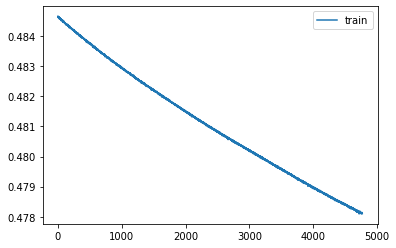

In [111]:
plt.figure()
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

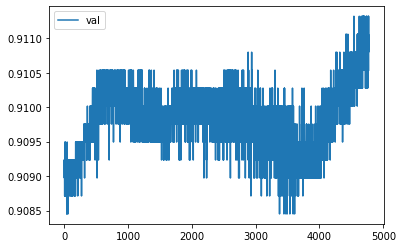

In [112]:
plt.figure()
# plt.plot(history.history['y1_categorical_accuracy'], label='train')
plt.plot(history.history['val_y1_categorical_accuracy'], label='val')
plt.legend()
plt.show()

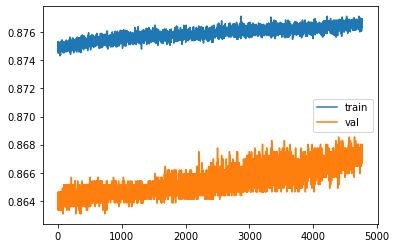

In [113]:
plt.figure()
plt.plot(history.history['y2_categorical_accuracy'], label='train')
plt.plot(history.history['val_y2_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [114]:
ymodel = model.predict(x_val)

In [115]:
ymodel1 = enc_y1.inverse_transform(ymodel[0])
y_act1 = enc_y1.inverse_transform(y_val1)
ymodel2 = enc_y2.inverse_transform(ymodel[1])
y_act2 = enc_y2.inverse_transform(y_val2)

In [116]:
from sklearn.metrics import f1_score

In [117]:
f1 = f1_score(ymodel1[:,0],y_act1[:,0],average='weighted')

In [118]:
f2 = f1_score(ymodel2[:,0],y_act2[:,0],average='weighted')

In [119]:
(f1+f2)*100/2

88.99686837376306

In [120]:
88.1122

88.1122